### **Project Summary**

The goal of this project is to use Natural Language Processing (NLP) models to predict whether a property listed on Airbnbwill be unlisted
in the next quarter. For this, you will resort to real **Airbnb property descriptions, Airbnb host descriptions, and comments from previous guests**. 

In summary, with the NLP techniques you will learn during the Text Mining course, you must implement an NLP classification model able to predict, for each property, if it was unlisted (1) or is still listed (0).

The project should be developed using Python and libraries such as NLTK, Scikit Learn, Keras or PyTorch. Also, the project can 
be solved in various ways, which means there is no exact correct solution. And, of course, groups should not use code from each other!

The corpora for the project is divided in following sets:
- Train (train.xlsx) (6,248 lines): Contains the Airbnb and host descriptions 
(“description” and “host_about” columns), as well as the information regarding the 
property listing status (“unlisted” column). A property is considered unlisted (1) if 
it got removed from the quarterly Airbnb list and it is considered listed (0) if it 
remains on that same list.
- Train Reviews (train_reviews.xlsx) (361,281 lines): This file has all the guests’ 
comments made to each Airbnb property. Note that there can be more than one 
comment per property, not all properties have comments, and comments can 
appear in many languages.
- Test (test.xlsx) (695 lines): The structure of this dataset is the same as the train 
set, except that it does not contain the “unlisted” column. The teaching team is 
keeping this information secret! You are expected to provide the predicted status 
(0 or 1) for each Airbnb in this set. Once the projects are delivered, we will compare 
your predictions with the actual (true) labels.
- Test Reviews (test_reviews.xlsx) (41,866 lines): The structure of this dataset is the 
same as the train reviews set, but the comments correspond to the properties 
present on the test set.

Note that you are not required to use all the textual fields from the provided corpora as 
input for your model. For example, your best solution may just use the “description” 
column as input.


**Our goal is to predict if a property was listed or unlisted, based on the input features: property description and/or host descriptions**

# **IMPORTS AND DATA LOADING**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EXPLORATORY ANALYSIS
from wordcloud import WordCloud
import string
import pycountry
from langdetect import detect, detect_langs 
from langdetect.lang_detect_exception import LangDetectException

# PREPROCESSING
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import RSLPStemmer  
from nltk.corpus import stopwords
import spacy
import unicodedata
from collections import Counter

from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
airbnb_df_train = pd.read_excel('Project Corpora/train.xlsx')
airbnb_reviews_df_train = pd.read_excel('Project Corpora/train_reviews.xlsx')

airbnb_df_test = pd.read_excel('Project Corpora/test.xlsx')
airbnb_reviews_df_test = pd.read_excel('Project Corpora/test_reviews.xlsx')

In [3]:
airbnb_df_train.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  Nous sommes une famille avec deux enfants de 1...         0

In [4]:
airbnb_reviews_df_train.head()

index                                           comments
0      1  this is a very cozy and comfortable house to s...
1      1                                          good<br/>
2      1  My first hostel experience, and all I have to ...
3      1  Das Hostel war neu und deshalb funktionierte a...
4      1  It was fine for a dorm, but I think for the pe...

In [5]:
airbnb_df_test.head()

index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious. This four-bed...   
3      4  Charming Apartment Close to the Bay of Cascais...   
4      5  Se procura umas férias perto da praia, casino ...   

                                          host_about  
0  Gosto de viajar, de conhecer pessoas, gosto de...  
1  We are the be@home Team!\n\nYou can count on u...  
2  Hi there!\n\nWe're GuestReady, a professional ...  
3                                                 :)  
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...

In [6]:
airbnb_reviews_df_test.head()

index                                           comments
0      1  Thank you very much Antonio ! All has been per...
1      1  Very nice appartment in the old town of Lissab...
2      1  When travelling we're looking for kids friendl...
3      1  We've been in Lisbon in march 2013 (3 adults a...
4      1  Our host Antonio was very helpful with informa...

# **EXPLORATORY ANALYSIS**

## Checking missing values

In [7]:
def check_missing_values(df):

    missing_info = df.isnull().sum()
    total_missing = missing_info.sum()

    if total_missing > 0:
        print(f"DataFrame contains {total_missing} missing values:")
        print(missing_info[missing_info > 0])  # Print only columns with missing values
    else:
        print("DataFrame has no missing values.")

check_missing_values(airbnb_df_train)
check_missing_values(airbnb_reviews_df_train)
check_missing_values(airbnb_df_test) 
check_missing_values(airbnb_reviews_df_test) 

DataFrame has no missing values.
DataFrame contains 2 missing values:
comments    2
dtype: int64
DataFrame has no missing values.
DataFrame has no missing values.


In [8]:
airbnb_reviews_df_train.dropna(inplace=True)

## Frequency of Target Variable

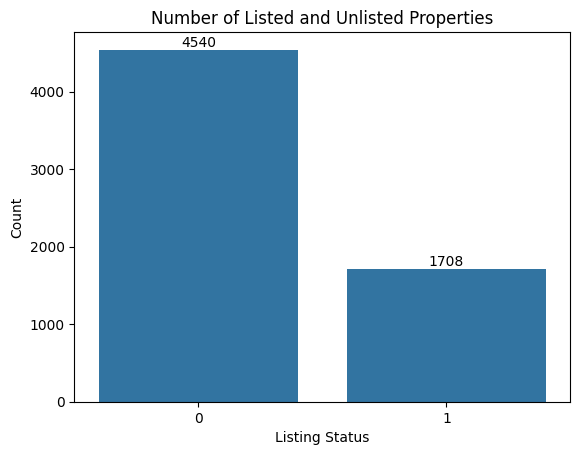

In [9]:
def plot_target_distribution(df, df_name, target_column):

    value_counts = df[target_column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values)

    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

    plt.ylabel('Count')
    plt.xlabel('Listing Status')
    plt.title('Number of Listed and Unlisted Properties')
    plt.show()

plot_target_distribution(airbnb_df_train, 'Train', 'unlisted')

## Word Count in Each Text

In [10]:
airbnb_df_train1 = airbnb_df_train.copy()
airbnb_reviews_df_train1 = airbnb_reviews_df_train.copy()

airbnb_df_train1['description_word_count']  = airbnb_df_train1['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train1['host_about_word_count']  = airbnb_df_train1['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_reviews_df_train1['comments_word_count']  = airbnb_reviews_df_train1['comments'].apply(lambda x: len(str(x).split(" ")))

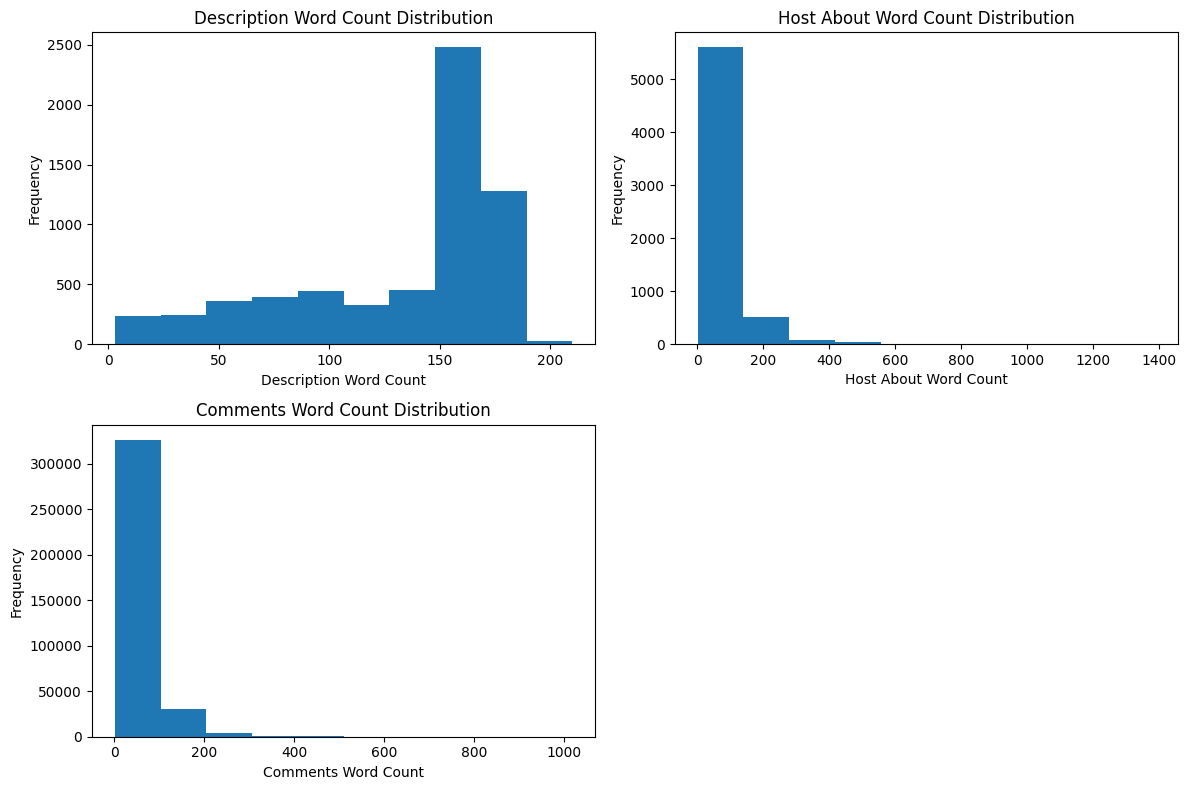

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot for description_word_count
axes[0, 0].hist(airbnb_df_train1['description_word_count'])
axes[0, 0].set_xlabel('Description Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Description Word Count Distribution')

# Plot for host_about_word_count
axes[0, 1].hist(airbnb_df_train1['host_about_word_count'])
axes[0, 1].set_xlabel('Host About Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Host About Word Count Distribution')

# Plot for comments_word_count
axes[1, 0].hist(airbnb_reviews_df_train1['comments_word_count'])
axes[1, 0].set_xlabel('Comments Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Comments Word Count Distribution')

fig.delaxes(axes[1][1])
plt.tight_layout()
plt.show()

## Most Frequent Words

In [12]:
all_words_description = ' '.join(airbnb_df_train1['description']).split()
all_words_host_about = ' '.join(airbnb_df_train1['host_about']).split()
all_words_comments = ' '.join(airbnb_reviews_df_train1['comments']).split()

freq_description = pd.Series(all_words_description).value_counts()
freq_host_about = pd.Series(all_words_host_about).value_counts()
freq_comments = pd.Series(all_words_comments).value_counts()

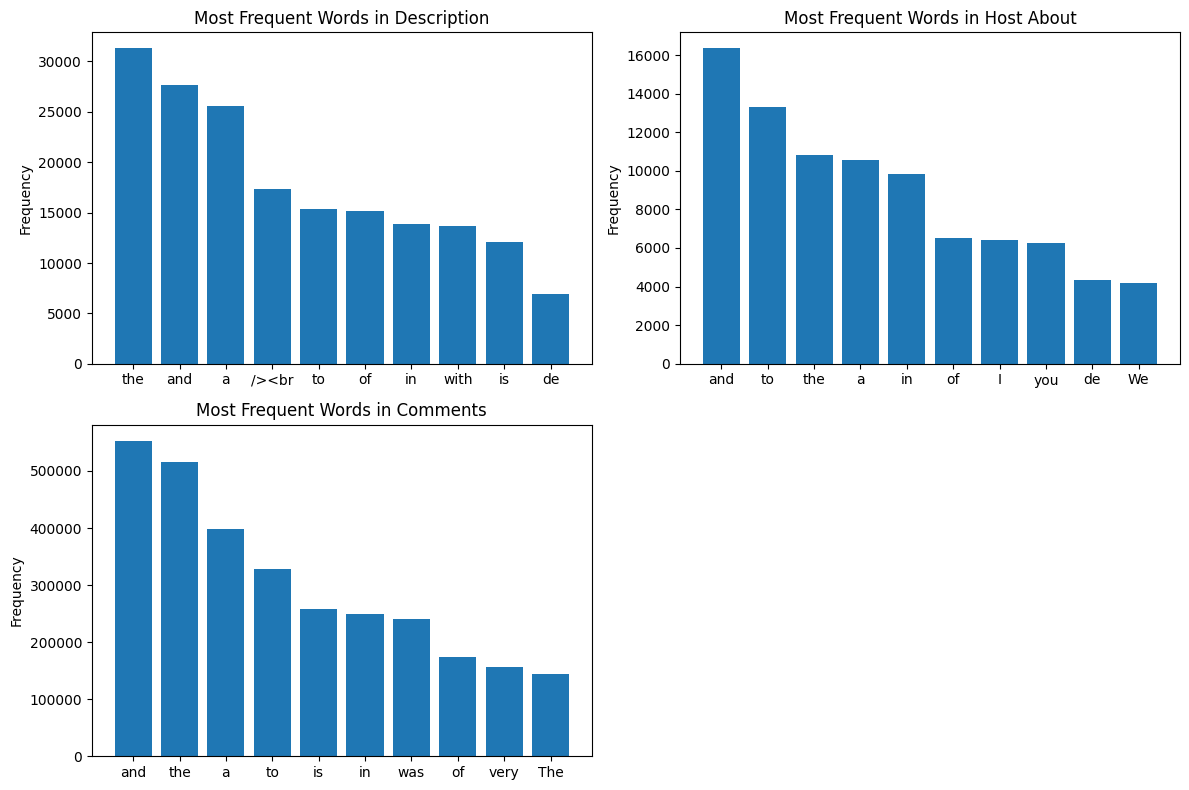

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

x_labels_desc = freq_description.index[0:10]
values_desc = freq_description[:10]
axes[0, 0].bar(x_labels_desc, values_desc)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Most Frequent Words in Description')

x_labels_host = freq_host_about.index[0:10]
values_host = freq_host_about[:10]
axes[0, 1].bar(x_labels_host, values_host)
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Most Frequent Words in Host About')

x_labels_comments = freq_comments.index[0:10]
values_comments = freq_comments[:10]
axes[1, 0].bar(x_labels_comments, values_comments)
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Most Frequent Words in Comments')

fig.delaxes(axes[1][1])
plt.tight_layout()
plt.show()

## Word Clouds

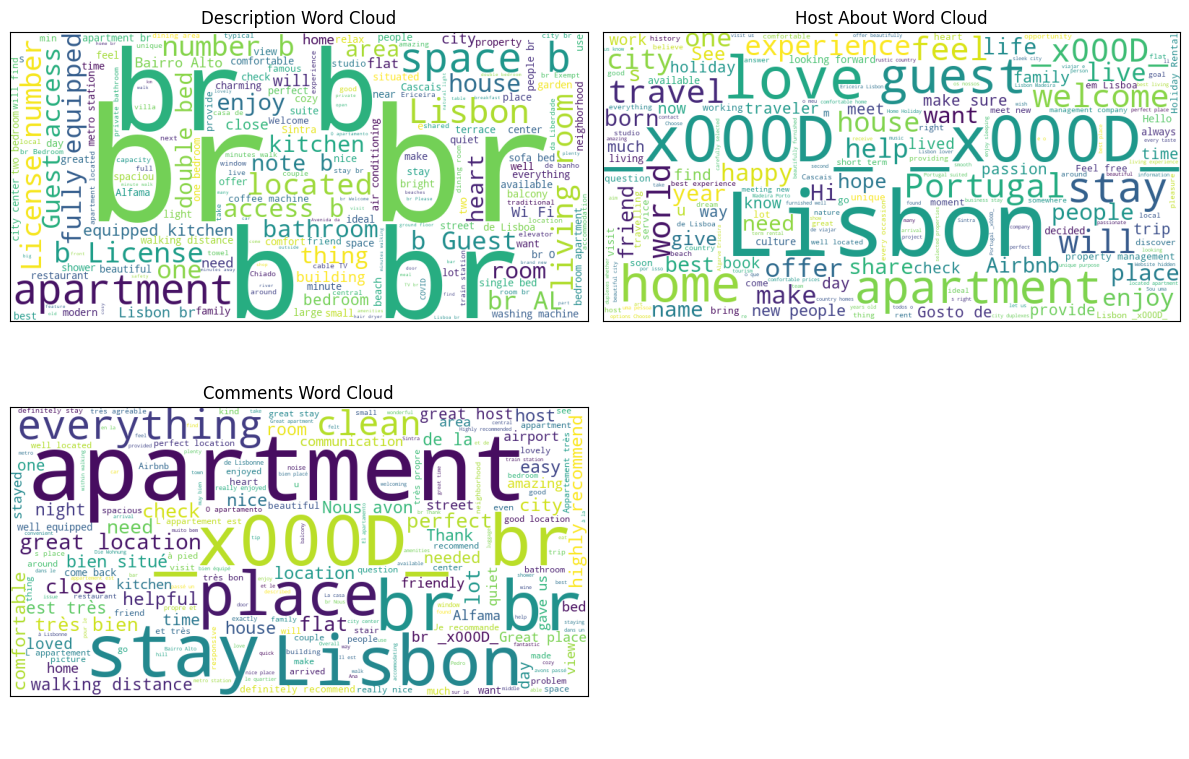

In [14]:
airbnb_df_train2 = airbnb_df_train1.copy()
airbnb_reviews_df_train2 = airbnb_reviews_df_train1.copy()

# Joining all the texts into single strings
all_descriptions = ' '.join(airbnb_df_train2['description'])
all_host_abouts= ' '.join(airbnb_df_train2['host_about'])
all_comments = ' '.join(airbnb_reviews_df_train2['comments'])
    
def generate_wordcloud(text_data, title, ax): 
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)
    ax.imshow(wordcloud)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

generate_wordcloud(all_descriptions, 'Description Word Cloud', axes[0, 0])
generate_wordcloud(all_host_abouts, 'Host About Word Cloud', axes[0, 1])
generate_wordcloud(all_comments, 'Comments Word Cloud', axes[1, 0])
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Checking Duplicated Rows

In [15]:
df_train = airbnb_df_train.copy()
df_test = airbnb_df_test.copy()

dfreview_train = airbnb_reviews_df_train.copy()
dfreview_test = airbnb_reviews_df_test.copy()

In [16]:
def check_duplicates(df, df_name):

    duplicated_rows = df.duplicated() 
    total_duplicates = duplicated_rows.sum()

    if total_duplicates > 0:
        print(f"{df_name} contains {total_duplicates} duplicated rows.")
    else:
        print(f"{df_name} has no duplicated rows.")

check_duplicates(df_train, 'airbnb_df_train')
check_duplicates(df_test, 'airbnb_df_test')
check_duplicates(dfreview_train, 'airbnb_reviews_df_train') 
check_duplicates(dfreview_test, 'airbnb_reviews_df_test')

airbnb_df_train has no duplicated rows.
airbnb_df_test has no duplicated rows.
airbnb_reviews_df_train contains 142 duplicated rows.
airbnb_reviews_df_test contains 15 duplicated rows.


In [17]:
for df, df_name in [(dfreview_train, 'airbnb_reviews_df_train'),
                    (dfreview_test, 'airbnb_reviews_df_test')]: 
    if df.duplicated().any():
        print(f"\nSample of duplicated rows in {df_name}:")
        print(df[df.duplicated(keep=False)].head(5)) 


Sample of duplicated rows in airbnb_reviews_df_train:
      index                                           comments
3248     61                                         Excelente!
3254     61                                         Excelente!
4225     70                              Everything was great!
4263     70                              Everything was great!
6584    144  Sofia is an incredible host, and made us feel ...

Sample of duplicated rows in airbnb_reviews_df_test:
       index      comments
1622      42   Great place
1645      42   Great place
8862     155          Good
8884     155          Good
11302    178  Great place!


In [18]:
def find_potential_duplicates_by_columns(df, df_name, columns=['description', 'host_about']):

    grouped_df = df.groupby(columns)  
    potential_duplicates = pd.DataFrame() 

    for name, group in grouped_df:
        if len(group) > 1: 
            potential_duplicates = pd.concat([potential_duplicates, group], ignore_index=True)  

    if not potential_duplicates.empty:
        num_duplicates = len(potential_duplicates)
        print(f"Different properties with the same columns {columns}: {num_duplicates}")
        display(potential_duplicates) 
    else:
        print(f"No different properties with the same columns: {columns}")  

find_potential_duplicates_by_columns(df_train, 'airbnb_df_train') 


Different properties with the same columns ['description', 'host_about']: 341


index                                        description  \
0     1936  #FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...   
1     1968  #FRIENDS WHO HAVEN'T MET YET! <br /><br />We t...   
2     2881  **Covid 19: If you are concerned about the cor...   
3     4031  **Covid 19: If you are concerned about the cor...   
4     2653  **Covid 19: If you are concerned about the cor...   
..     ...                                                ...   
336   4524  there are  6 rooms in this apartment.  this ro...   
337     58  there are 4 rooms in this apartment. this room...   
338   5006  there are 4 rooms in this apartment. this room...   
339   1667  ￫ Charming apartment perfectly located walking...   
340   2944  ￫ Charming apartment perfectly located walking...   

                                            host_about  unlisted  
0    hi everyone\nJust a 22 year old making new fri...         0  
1    hi everyone\nJust a 22 year old making new fri...         0  
2    LovelyStay is one of the leading property mana...         0  
3    LovelyStay is one of the leading property mana...         0  
4    This apartment is maintained and taken care of...         0  
..                                                 ...       ...  
336                  我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.          0  
337                  我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.          0  
338                  我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.          0  
339  I am an interior designer, plant lover, and wo...         1  
340  I am an interior designer, plant lover, and wo...         1  

[341 rows x 4 columns]

## Multiple Languages Study

In [19]:
def safe_language_detection(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

def analyze_languages(df, text_columns, reviews_df=None):
    language_summary = pd.DataFrame(columns=text_columns)

    for col in text_columns:
        df[f'{col}_language'] = df[col].apply(safe_language_detection)
        language_summary[col] = df[f'{col}_language'].value_counts()

    if reviews_df is not None:
        reviews_df['comments_language'] = reviews_df['comments'].apply(safe_language_detection)
        language_summary['comments'] = reviews_df['comments_language'].value_counts()

    return language_summary.fillna(0)

In [20]:
result = analyze_languages(
    df_train.copy(), 
    ['description', 'host_about'], 
    dfreview_train.copy()
) 
result

description  host_about  comments
description_language                                   
en                           5108        4443    232308
pt                            907        1276     22443
fr                             84         135     53281
da                             57           1       460
de                             45          56     14213
es                             28          84     19231
sv                              4           4       372
it                              4          45      5679
no                              3           7       302
ca                              3          38       573
zh-cn                           3          28      1040
nl                              2          10      3581

In [21]:
result1 = analyze_languages(
    df_test.copy(), 
    ['description', 'host_about'], 
    dfreview_test.copy()
) 
result1

description  host_about  comments
description_language                                   
en                            576       504.0     27592
pt                             96       134.0      2184
da                             11         0.0        46
fr                              7        17.0      5926
de                              2         5.0      1744
es                              2         8.0      2173
ca                              1         2.0        64

In [22]:
print("Shape of 'result' DataFrame:", result.shape)
print("Shape of 'df_train' DataFrame:", df_train.shape)
print("Shape of 'dfreview_train' DataFrame:", dfreview_train.shape)

print("Shape of 'result1' DataFrame:", result1.shape)
print("Shape of 'df_test' DataFrame:", df_test.shape)
print("Shape of 'dfreview_test' DataFrame:", dfreview_test.shape)

Shape of 'result' DataFrame: (12, 3)
Shape of 'df_train' DataFrame: (6248, 4)
Shape of 'dfreview_train' DataFrame: (361279, 2)
Shape of 'result1' DataFrame: (7, 3)
Shape of 'df_test' DataFrame: (695, 3)
Shape of 'dfreview_test' DataFrame: (41866, 2)


Languages Dict:

en: English \ pt: Portuguese \ fr: French \ da: Danish \ de: German \ es: Spanish \ no: Norwegian \ ca: Catalan \ zh-cn: Chinese (Simplified) \ it: Italian \ nl: Dutch \ sv: Swedish

# **DATA PREPROCESSING**

In [23]:
# CREATING COLUMNS THAT IDENTIFY THE LANGUAGE OF EACH TEXT BASED VARIABLE

# TRAIN DATA
for col in ['description', 'host_about']:
    df_train[f'{col}_language'] = df_train[col].astype(str).apply(safe_language_detection)

dfreview_train['comments_language'] = dfreview_train['comments'].astype(str).apply(safe_language_detection)

# TEST DATA
for col in ['description', 'host_about']:
    df_test[f'{col}_language'] = df_test[col].astype(str).apply(safe_language_detection)

dfreview_test['comments_language'] = dfreview_test['comments'].astype(str).apply(safe_language_detection)

In [24]:
df_train

index                                        description  \
0         1  This is a shared mixed room in our hostel, wit...   
1         2  O meu espaço fica perto de Parque Eduardo VII,...   
2         3  Trafaria’s House is a cozy and familiar villa ...   
3         4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4         5  Joli appartement  en bordure de mer.<br /> 2 m...   
...     ...                                                ...   
6243   6244  Studio 15 is a new, very well decorated and co...   
6244   6245  Lisbon meets a cosmopolitan industrial one-bed...   
6245   6246                  <b>License number</b><br />Exempt   
6246   6247  Campo Pequeno Prestige is a classy and top qua...   
6247   6248  These apartments are very well located in a go...   

                                             host_about  unlisted  \
0                   Alojamento Local Registro: 20835/AL         0   
1     I am friendly host, and I will try to always b...         1   
2     I am a social person liking to communicate, re...         1   
3     Hello!_x000D_\nI m Portuguese and i love to me...         0   
4     Nous sommes une famille avec deux enfants de 1...         0   
...                                                 ...       ...   
6243  I'm a Brand Manager from Lisbon in Portugal bu...         0   
6244  Home is where feelings are visitors. How do we...         0   
6245  I am a travel agent passionate by cultures. \n...         1   
6246  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0   
6247  A base da minha vida é a minha família e a min...         0   

     description_language host_about_language  
0                      en                  pt  
1                      pt                  en  
2                      en                  en  
3                      pt                  en  
4                      fr                  fr  
...                   ...                 ...  
6243                   en                  en  
6244                   en                  en  
6245                   en                  en  
6246                   en                  pt  
6247                   en                  pt  

[6248 rows x 6 columns]

In [25]:
dfreview_test

index                                           comments  \
0          1  Thank you very much Antonio ! All has been per...   
1          1  Very nice appartment in the old town of Lissab...   
2          1  When travelling we're looking for kids friendl...   
3          1  We've been in Lisbon in march 2013 (3 adults a...   
4          1  Our host Antonio was very helpful with informa...   
...      ...                                                ...   
41861    695                               Everything was fine!   
41862    695                                  Very good located   
41863    695  Appartement confortable conforme aux photos bi...   
41864    695  Très bon logement pour un week-end prolongé à ...   
41865    695  The location for this apartment is great. You'...   

      comments_language  
0                    en  
1                    en  
2                    en  
3                    en  
4                    en  
...                 ...  
41861                en  
41862                en  
41863                fr  
41864                fr  
41865                en  

[41866 rows x 3 columns]

In [26]:
unknown_description_count1 = (df_train['description_language'] == 'unknown').sum()
unknown_host_about_count1 = (df_train['host_about_language'] == 'unknown').sum()

unknown_description_count2 = (df_test['description_language'] == 'unknown').sum()
unknown_host_about_count2 = (df_test['host_about_language'] == 'unknown').sum()

unknown_comments_count1 = (dfreview_train['comments_language'] == 'unknown').sum()
unknown_comments_count2 = (dfreview_test['comments_language'] == 'unknown').sum()

print('TRAIN DATA')
print(f"Unknown values in 'description_language': {unknown_description_count1}")
print(f"Unknown values in 'host_about_language': {unknown_host_about_count1}")
print(f"Unknown values in 'comments_language': {unknown_comments_count1}")
print('\n')
print('TEST DATA')
print(f"Unknown values in 'host_about_language': {unknown_description_count1}")
print(f"Unknown values in 'description_language': {unknown_host_about_count2}")
print(f"Unknown values in 'comments_language': {unknown_comments_count2}")

TRAIN DATA
Unknown values in 'description_language': 0
Unknown values in 'host_about_language': 67
Unknown values in 'comments_language': 918


TEST DATA
Unknown values in 'host_about_language': 0
Unknown values in 'description_language': 10
Unknown values in 'comments_language': 125


In [27]:
print("Shape of 'df_train' DataFrame:", df_train.shape)
print("Shape of 'dfreview_train' DataFrame:", dfreview_train.shape)
print("Shape of 'df_test' DataFrame:", df_test.shape)
print("Shape of 'dfreview_test' DataFrame:", dfreview_test.shape)

Shape of 'df_train' DataFrame: (6248, 6)
Shape of 'dfreview_train' DataFrame: (361279, 3)
Shape of 'df_test' DataFrame: (695, 5)
Shape of 'dfreview_test' DataFrame: (41866, 3)


In [28]:
df_train_spacy = df_train.copy()
dfreview_train_spacy = dfreview_train.copy()

df_test_spacy = df_test.copy()
dfreview_test_spacy = dfreview_test.copy()

In [29]:
df_train_original = df_train.copy()
dfreview_train_original = dfreview_train.copy()

df_test_original = df_test.copy()
dfreview_test_original = dfreview_test.copy()

In [30]:
# LETS REMOVE THE ROWS WITH UNKNOWN TEXT LANGUAGE

df_train = df_train[
    (df_train['description_language'] != 'unknown') 
    & (df_train['host_about_language'] != 'unknown')
]
dfreview_train = dfreview_train[dfreview_train['comments_language'] != 'unknown']


df_test = df_test[
    (df_test['description_language'] != 'unknown') 
    & (df_test['host_about_language'] != 'unknown')
]
dfreview_test = dfreview_test[dfreview_test['comments_language'] != 'unknown']

## Building the Preprocessing Pipeline

### NLTK

In [31]:
# https://www.nltk.org/api/nltk.stem.SnowballStemmer.html?highlight=stopwords

In [32]:
def clean_nltk(text, detected_language, lemmatize=False, apply_stemmer=False):
    text = emoji.replace_emoji(text, replace='')
    text = text.lower()
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text) 

    stop_words = set()  # Initialize for cases where language is not EN or PT

    if detected_language == 'en':
        stop_words = set(stopwords.words('english'))
    elif detected_language == 'pt': 
        stop_words = set(stopwords.words('portuguese'))

    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    # Lemmatization or Stemming (choose one, preferably lemmatization)
    if lemmatize and detected_language == 'en':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    if apply_stemmer:
        if detected_language == 'en':
            stemmer = SnowballStemmer('english')
        elif detected_language == 'pt':
            stemmer = SnowballStemmer('portuguese')
        else:
            stemmer = None

        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

    text = " ".join(tokens)
    return text

In [33]:
df_train['description_cleaned_nltk'] = df_train.apply(lambda row: clean_nltk(row['description'], row['description_language'], lemmatize=True, apply_stemmer=True), axis=1)
df_test['description_cleaned_nltk'] = df_test.apply(lambda row: clean_nltk(row['description'], row['description_language'], lemmatize=True, apply_stemmer=True), axis=1)

df_train['host_about_cleaned_nltk'] = df_train.apply(lambda row: clean_nltk(row['host_about'], row['host_about_language'], lemmatize=True, apply_stemmer=True), axis=1)
df_test['host_about_cleaned_nltk'] = df_test.apply(lambda row: clean_nltk(row['host_about'], row['host_about_language'], lemmatize=True, apply_stemmer=True), axis=1)

C:\Users\Filipe\AppData\Local\Temp\ipykernel_2696\1716991529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['description_cleaned_nltk'] = df_train.apply(lambda row: clean_nltk(row['description'], row['description_language'], lemmatize=True, apply_stemmer=True), axis=1)
C:\Users\Filipe\AppData\Local\Temp\ipykernel_2696\1716991529.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['host_about_cleaned_nltk'] = df_train.apply(lambda row: clean_nltk(row['host_about'], row['host_about_lang

In [34]:
df_train.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  \
0                   en                  pt   
1                   pt                  en   
2                   en                  en   
3                   pt                  en   
4                   fr                  fr   

                            description_cleaned_nltk  \
0  share mix room hostel share bathroomw locat ri...   
1  espac fic pert parqu eduard vii saldanh estefa...   
2  trafaria hous cozi familiar villa facil need r...   
3  apart charmos chi larg carm travess trindad es...   
4  joli appartement en bordure de mer min a pied ...   

                             host_about_cleaned_nltk  
0                                 aloj local registr  
1  friend host tri alway around need anyth though...  
2  social person like communic read travel like c...  
3  portugues love meet peopl around word mayb one...  
4  nous sommes une famille avec deux enfants de e...

In [35]:
def clean_nltk_comments(text, detected_language, lemmatize=False, apply_stemmer=False):
    text = emoji.replace_emoji(text, replace='')
    text = text.lower()
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"[^\w\s]", "", text) 
    tokens = word_tokenize(text) 

    stop_words = set()

    if detected_language == 'en':
        stop_words = set(stopwords.words('english'))
    elif detected_language == 'pt': 
        stop_words = set(stopwords.words('portuguese'))
    elif detected_language == 'fr': 
        stop_words = set(stopwords.words('french'))
    elif detected_language == 'de': 
        stop_words = set(stopwords.words('german'))
    elif detected_language == 'es': 
        stop_words = set(stopwords.words('spanish'))

    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    if lemmatize and detected_language == 'en':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    if apply_stemmer:
        if detected_language == 'en':
            stemmer = SnowballStemmer('english')
        elif detected_language == 'pt':
            stemmer = SnowballStemmer('portuguese')
        elif detected_language == 'fr':
            stemmer = SnowballStemmer('french')
        elif detected_language == 'de':
            stemmer = SnowballStemmer('german')
        elif detected_language == 'es':
            stemmer = SnowballStemmer('spanish')
        else:
            stemmer = None

        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

    text = " ".join(tokens)
    return text

In [36]:
dfreview_train['comments_cleaned_nltk'] = dfreview_train.apply(lambda row: clean_nltk_comments(row['comments'], row['comments_language'], lemmatize=True, apply_stemmer=True), axis=1)
dfreview_test['comments_cleaned_nltk'] = dfreview_test.apply(lambda row: clean_nltk_comments(row['comments'], row['comments_language'], lemmatize=True, apply_stemmer=True), axis=1)

C:\Users\Filipe\AppData\Local\Temp\ipykernel_2696\1028559998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfreview_test['comments_cleaned_nltk'] = dfreview_test.apply(lambda row: clean_nltk_comments(row['comments'], row['comments_language'], lemmatize=True, apply_stemmer=True), axis=1)


In [37]:
dfreview_train.head()

index                                           comments comments_language  \
0      1  this is a very cozy and comfortable house to s...                en   
1      1                                          good<br/>                cy   
2      1  My first hostel experience, and all I have to ...                en   
3      1  Das Hostel war neu und deshalb funktionierte a...                de   
4      1  It was fine for a dorm, but I think for the pe...                en   

                               comments_cleaned_nltk  
0  cozi comfort hous stay innev worri safeti host...  
1                                               good  
2  first hostel experi say pretti hard beat book ...  
3  hostel neu deshalb funktioniert tadellos schne...  
4  fine dorm think peopl stay far le bathroom toi...

In [38]:
df_train_nltk = df_train.copy()
dfreview_train_nltk  = dfreview_train.copy()

df_test_nltk  = df_test.copy()
dfreview_test_nltk  = dfreview_test.copy()

### SPACY

In [39]:
# https://spacy.io/models

# SpaCy models
nlp_en = spacy.load("en_core_web_sm")
nlp_pt = spacy.load("pt_core_news_sm")
nlp_fr = spacy.load("fr_core_news_sm")
nlp_es = spacy.load("es_core_news_sm")
nlp_de = spacy.load("de_core_news_sm")


# mapping language codes to SpaCy models
nlp_models = {
    'en': nlp_en,
    'pt': nlp_pt,
    'fr': nlp_fr,
    'es': nlp_es,
    'de': nlp_de
}

In [40]:
def preprocess_text(text, language):
    nlp = nlp_models.get(language, nlp_en)

    doc = nlp(text)
    cleaned_tokens = [
        unicodedata.normalize('NFKD', token.lemma_.lower()).encode('ascii', 'ignore').decode('utf-8')
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]

    # Remove single-letter tokens
    cleaned_tokens = [token for token in cleaned_tokens if len(token) > 1]

    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text


def clean_spacy(df, text_column, language_column):
    preprocessed_text = []
    for text, language in tqdm(zip(df[text_column], df[language_column])):
        cleaned_text = preprocess_text(text, language)
        preprocessed_text.append(cleaned_text)
        
    df[f'{text_column}_preprocessed'] = preprocessed_text
    return df

In [41]:
df_train_spacy = clean_spacy(df_train_spacy, "description", "description_language")
df_train_spacy = clean_spacy(df_train_spacy, "host_about", "host_about_language")

df_test_spacy = clean_spacy(df_test_spacy, "description", "description_language")
df_test_spacy = clean_spacy(df_test_spacy, "host_about", "host_about_language")

dfreview_train_spacy = clean_spacy(dfreview_train_spacy, "comments", "comments_language")
dfreview_test_spacy = clean_spacy(dfreview_test_spacy, "comments", "comments_language")

6248it [01:47, 57.86it/s]
6248it [01:10, 88.56it/s] 
695it [00:12, 57.20it/s]
695it [00:08, 86.86it/s] 
361279it [47:13, 127.50it/s]
41866it [05:27, 127.99it/s]


In [42]:
df_train_spacy.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  \
0                   en                  pt   
1                   pt                  en   
2                   en                  en   
3                   pt                  en   
4                   fr                  fr   

                            description_preprocessed  \
0  share mixed room hostel share locate right str...   
1  espaco ficar parque eduardo vii saldanha estef...   
2  trafaria house cozy familiar villa facility ne...   
3  apartamento charmoso chiado largo carmo traves...   
4  joli appartemer bordure min pied magnifique oc...   

                             host_about_preprocessed  
0                             alojamento registro al  
1      friendly host try need quit strict house rule  
2  social person like communicate read travelling...  
3  portuguese love meet people word maybe reason ...  
4  etre famille enfant an habiter annee portugal ...

## Sentiment Analysis

We will do sentiment analisys on the comments, and then create variables based on the polarity of the comments. We will use the original comments instead of the cleaned ones, as we will be using twitter-xlm-roberta-base-sentiment, which is a transformer that can understand context and semantic meaning, and can handle raw text efficiently

In [43]:
dfreview_train_original

index                                           comments  \
0           1  this is a very cozy and comfortable house to s...   
1           1                                          good<br/>   
2           1  My first hostel experience, and all I have to ...   
3           1  Das Hostel war neu und deshalb funktionierte a...   
4           1  It was fine for a dorm, but I think for the pe...   
...       ...                                                ...   
361276   6248  The location was perfect. The apartment was ve...   
361277   6248  Ana's place is exactly as described and even b...   
361278   6248  A Ana foi muito atenciosa e preocupou se com o...   
361279   6248  No wifi nor answer. <br/>The wifi can’t be con...   
361280   6248  O espaço é ótimo, a D. Ana foi maravilhosa e f...   

       comments_language  
0                     en  
1                     cy  
2                     en  
3                     de  
4                     en  
...                  ...  
361276                en  
361277                en  
361278                pt  
361279                en  
361280                pt  

[361279 rows x 3 columns]

In [44]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

device = 0 if torch.cuda.is_available() else -1

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')

# Create a pipeline for sentiment analysis with truncation and padding
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, truncation=True, padding=True, max_length=512, device=device)

def sentiment_analysis(df, column_name):
    text_data = df[column_name].tolist()

    batch_size = 64  
    results = []
    for i in tqdm(range(0, len(text_data), batch_size), desc=f"Processing {column_name}"):
        batch = text_data[i:i + batch_size]
        batch_results = sentiment_pipeline(batch)
        results.extend(batch_results)

    sentiments = [result['label'] for result in results]
    df[f'{column_name}_sentiment'] = sentiments
    return df

# Process both DataFrames
dfreview_train_original = sentiment_analysis(dfreview_train_original, "comments")

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing comments: 100%|██████████| 5645/5645 [1:28:40<00:00,  1.06it/s]


Now we create 4 variables:
* reviews: number of reviews
* negative: number of negative comments
* neutral: number of neutral comments
* positive: number of positive comments

In [45]:
# Group by 'index' column and count occurrences of each sentiment
sentiment_counts = dfreview_train_original.groupby(['index', 'comments_sentiment']).size().unstack(fill_value=0)

# Reset index to make 'index' a regular column
sentiment_counts.reset_index(inplace=True)

# Rename columns for clarity
sentiment_counts.columns.name = None  # Remove the column name
sentiment_counts.rename(columns={'index': 'index', 'negative': 'negative', 'neutral': 'neutral', 'positive': 'positive'}, inplace=True)

# Display the resulting DataFrame
sentiment_counts['reviews'] = sentiment_counts['negative'] + sentiment_counts['neutral'] + sentiment_counts['positive']
sentiment_counts


index  negative  neutral  positive  reviews
0         1         4        4        42       50
1         5         0        0        41       41
2         8         4        1       163      168
3         9         1        2        30       33
4        10         3        0        10       13
...     ...       ...      ...       ...      ...
4240   6244         2        1        97      100
4241   6245         4        2       124      130
4242   6246         1        2        22       25
4243   6247         3        1        21       25
4244   6248        13       11       251      275

[4245 rows x 5 columns]

We will add a binary variable that tells us whether a property has comments or not, due to the high quantity of unlisted properties that have no comments

In [46]:
df_train_original['reviews_exist'] = df_train_original['index'].apply(lambda x: 1 if x in sentiment_counts['index'].values else 0)
df_train_spacy['reviews_exist'] = df_train_spacy['index'].apply(lambda x: 1 if x in sentiment_counts['index'].values else 0)
df_train_nltk['reviews_exist'] = df_train_nltk['index'].apply(lambda x: 1 if x in sentiment_counts['index'].values else 0)
df_train_original.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  reviews_exist  
0                   en                  pt              1  
1                   pt                  en              0  
2                   en                  en              0  
3                   pt                  en              0  
4                   fr                  fr              1

Join sentiment columns by index

In [47]:
df_train_original = df_train_original.merge(sentiment_counts, on='index', how='left')
df_train_spacy = df_train_spacy.merge(sentiment_counts, on='index', how='left')
df_train_nltk = df_train_nltk.merge(sentiment_counts, on='index', how='left')
df_train_original.head()

index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  reviews_exist  negative  neutral  \
0                   en                  pt              1       4.0      4.0   
1                   pt                  en              0       NaN      NaN   
2                   en                  en              0       NaN      NaN   
3                   pt                  en              0       NaN      NaN   
4                   fr                  fr              1       0.0      0.0   

   positive  reviews  
0      42.0     50.0  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4      41.0     41.0

We are going to fill NA with zeros

In [48]:
df_train_original.isnull().sum()

index                      0
description                0
host_about                 0
unlisted                   0
description_language       0
host_about_language        0
reviews_exist              0
negative                2003
neutral                 2003
positive                2003
reviews                 2003
dtype: int64

In [49]:
df_train_original.fillna(0, inplace=True)
df_train_spacy.fillna(0, inplace=True)
df_train_nltk.fillna(0, inplace=True)

In [50]:
df_train_original.drop(columns=['index'], inplace=True)
df_train_spacy.drop(columns=['index'], inplace=True)
df_train_nltk.drop(columns=['index'], inplace=True)
df_train_original.head()

description  \
0  This is a shared mixed room in our hostel, wit...   
1  O meu espaço fica perto de Parque Eduardo VII,...   
2  Trafaria’s House is a cozy and familiar villa ...   
3  Apartamento Charmoso no Chiado, Entre o Largo ...   
4  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  reviews_exist  negative  neutral  \
0                   en                  pt              1       4.0      4.0   
1                   pt                  en              0       0.0      0.0   
2                   en                  en              0       0.0      0.0   
3                   pt                  en              0       0.0      0.0   
4                   fr                  fr              1       0.0      0.0   

   positive  reviews  
0      42.0     50.0  
1       0.0      0.0  
2       0.0      0.0  
3       0.0      0.0  
4      41.0     41.0

Save to csv

In [51]:
# import os
# os.makedirs('data', exist_ok=True)

# df_train_original.to_csv('data/df_train_original.csv', index=False)
# df_train_spacy.to_csv('data/df_train_spacy.csv', index=False)
# df_train_nltk.to_csv('data/df_train_nltk.csv', index=False)

Read csv

In [1]:
import pandas as pd

df_train_original = pd.read_csv('data/df_train_original.csv')
df_train_spacy = pd.read_csv('data/df_train_spacy.csv')
df_train_nltk = pd.read_csv('data/df_train_nltk.csv')

In [53]:
df_train_original.isnull().sum()

description             0
host_about              0
unlisted                0
description_language    0
host_about_language     0
reviews_exist           0
negative                0
neutral                 0
positive                0
reviews                 0
dtype: int64

In [54]:
df_train_spacy.isnull().sum()

description                   0
host_about                    0
unlisted                      0
description_language          0
host_about_language           0
description_preprocessed      1
host_about_preprocessed     125
reviews_exist                 0
negative                      0
neutral                       0
positive                      0
reviews                       0
dtype: int64

In [55]:
df_train_nltk.isnull().sum()

description                  0
host_about                   0
unlisted                     0
description_language         0
host_about_language          0
description_cleaned_nltk     0
host_about_cleaned_nltk     14
reviews_exist                0
negative                     0
neutral                      0
positive                     0
reviews                      0
dtype: int64

In [2]:
df_train_spacy.fillna('', inplace=True)
df_train_nltk.fillna('', inplace=True)

# **MORE DATA EXPLORATION**

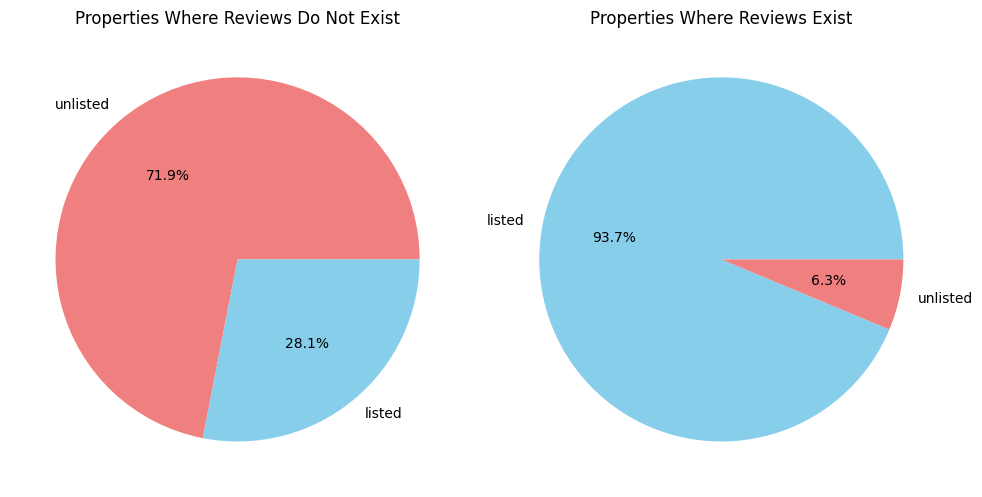

In [57]:
import matplotlib.pyplot as plt

# Filter DataFrame for reviews_exist == 0 and 1
df_reviews_0 = df_train_original[df_train_original['reviews_exist'] == 0]
df_reviews_1 = df_train_original[df_train_original['reviews_exist'] == 1]

# Count listings for each reviews_exist class
unlisted_counts_0 = df_reviews_0['unlisted'].value_counts()
unlisted_counts_1 = df_reviews_1['unlisted'].value_counts()

# Rename index labels for clarity
unlisted_counts_0.index = ['listed' if idx == 0 else 'unlisted' for idx in unlisted_counts_0.index]
unlisted_counts_1.index = ['listed' if idx == 0 else 'unlisted' for idx in unlisted_counts_1.index]

# Define the colors
colors = {'listed': 'skyblue', 'unlisted': 'lightcoral'}

# Plot pie chart for reviews_exist = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(unlisted_counts_0, labels=unlisted_counts_0.index, autopct='%1.1f%%', colors=[colors[label] for label in unlisted_counts_0.index])
plt.title('Properties Where Reviews Do Not Exist')

# Plot pie chart for reviews_exist = 1
plt.subplot(1, 2, 2)
plt.pie(unlisted_counts_1, labels=unlisted_counts_1.index, autopct='%1.1f%%', colors=[colors[label] for label in unlisted_counts_1.index])
plt.title('Properties Where Reviews Exist')

plt.tight_layout()
plt.show()


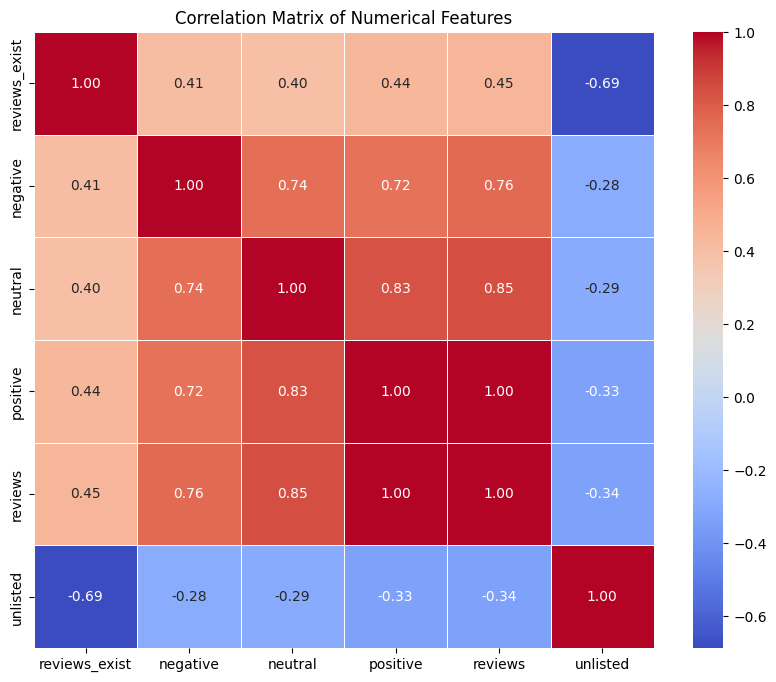

In [58]:
# Select numerical features and target variable
numerical_features = ['reviews_exist', 'negative', 'neutral', 'positive', 'reviews', 'unlisted']

# Compute correlation matrix
correlation_matrix = df_train_original[numerical_features].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

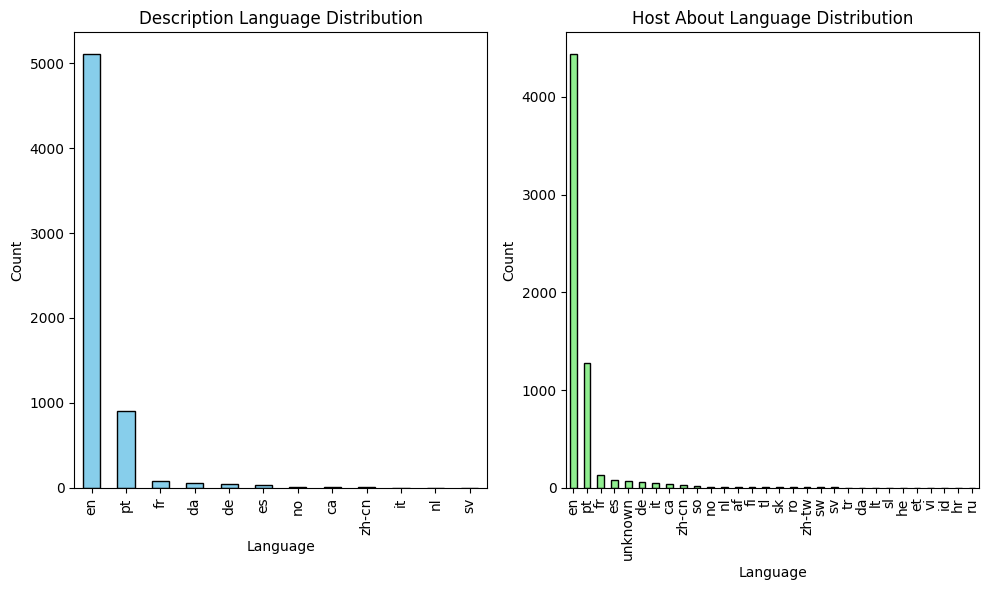

In [59]:
plt.figure(figsize=(10, 6))
description_lang_counts = df_train_original['description_language'].value_counts()
host_about_lang_counts = df_train_original['host_about_language'].value_counts()

plt.subplot(1, 2, 1)
description_lang_counts.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Description Language Distribution')
plt.xlabel('Language')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
host_about_lang_counts.plot(kind='bar', color='lightgreen', edgecolor='k')
plt.title('Host About Language Distribution')
plt.xlabel('Language')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

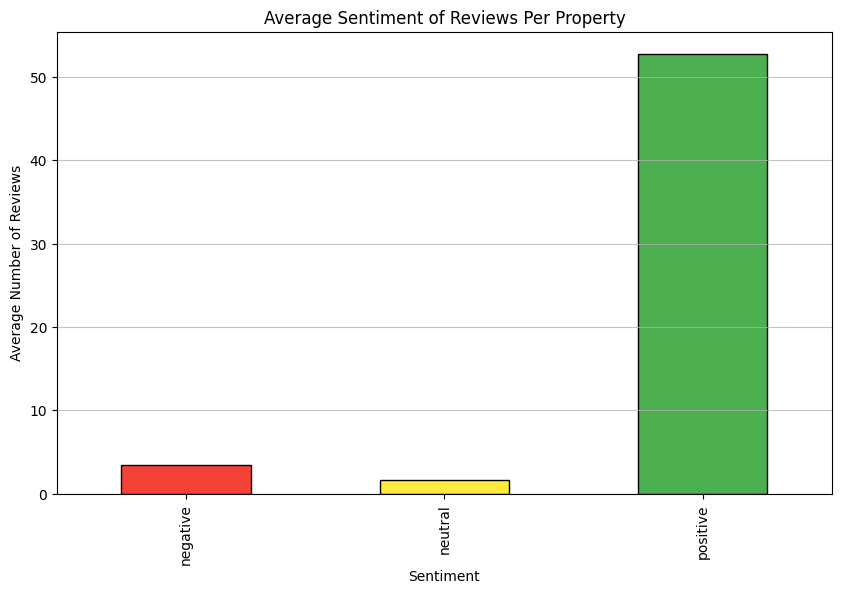

In [60]:
# average sentiment values
average_sentiments = df_train_original[['negative', 'neutral', 'positive']].mean()

plt.figure(figsize=(10, 6))
average_sentiments.plot(kind='bar', color=['#f44336', '#ffeb3b', '#4caf50'], edgecolor='k')
plt.title('Average Sentiment of Reviews Per Property')
plt.xlabel('Sentiment')
plt.ylabel('Average Number of Reviews')
plt.grid(axis='y', alpha=0.75)
plt.show()

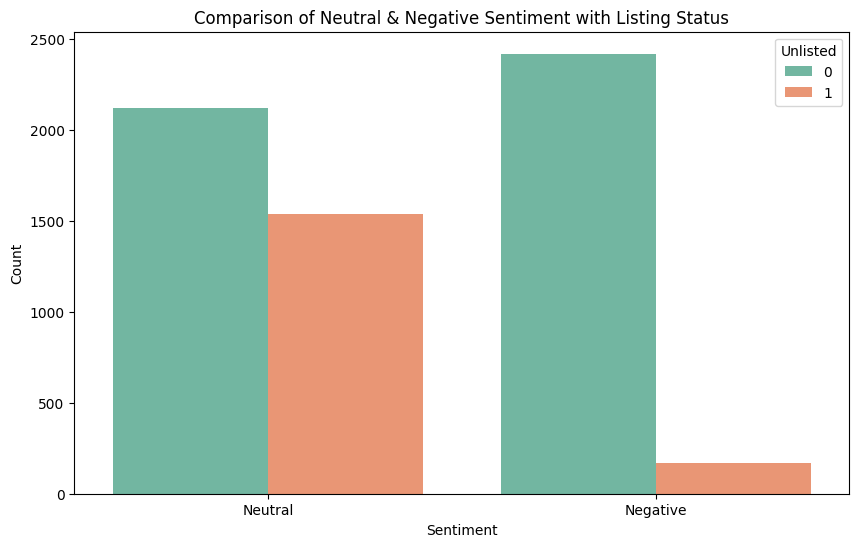

In [61]:
df_train_original['average_negative'] = df_train_original['negative']
df_train_original['average_neutral'] = df_train_original['neutral']

def classify_sentiment(row):
    if row['average_negative'] > row['average_neutral']:
        return 'Negative'
    else:
        return 'Neutral'

df_train_original['sentiment_class'] = df_train_original.apply(classify_sentiment, axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_class', hue='unlisted', data=df_train_original, palette='Set2')
plt.title('Comparison of Neutral & Negative Sentiment with Listing Status')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Unlisted', loc='upper right')
plt.show()

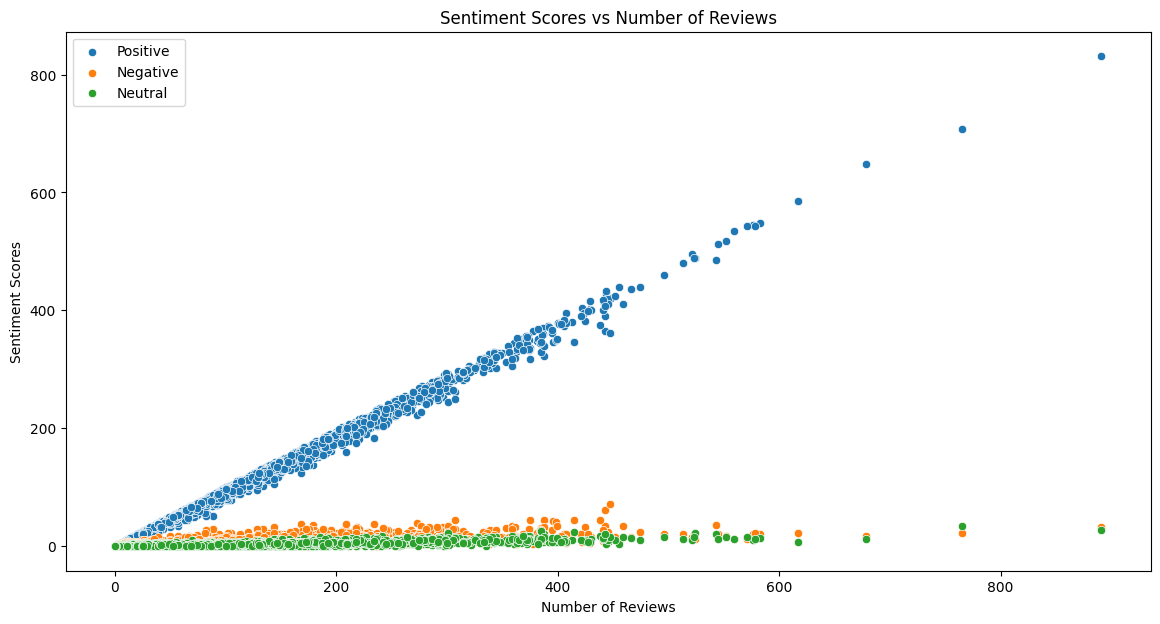

In [64]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='reviews', y='positive', data=df_train_original, label='Positive')
sns.scatterplot(x='reviews', y='negative', data=df_train_original, label='Negative')
sns.scatterplot(x='reviews', y='neutral', data=df_train_original, label='Neutral')
plt.title('Sentiment Scores vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Sentiment Scores')
plt.legend()
plt.show()

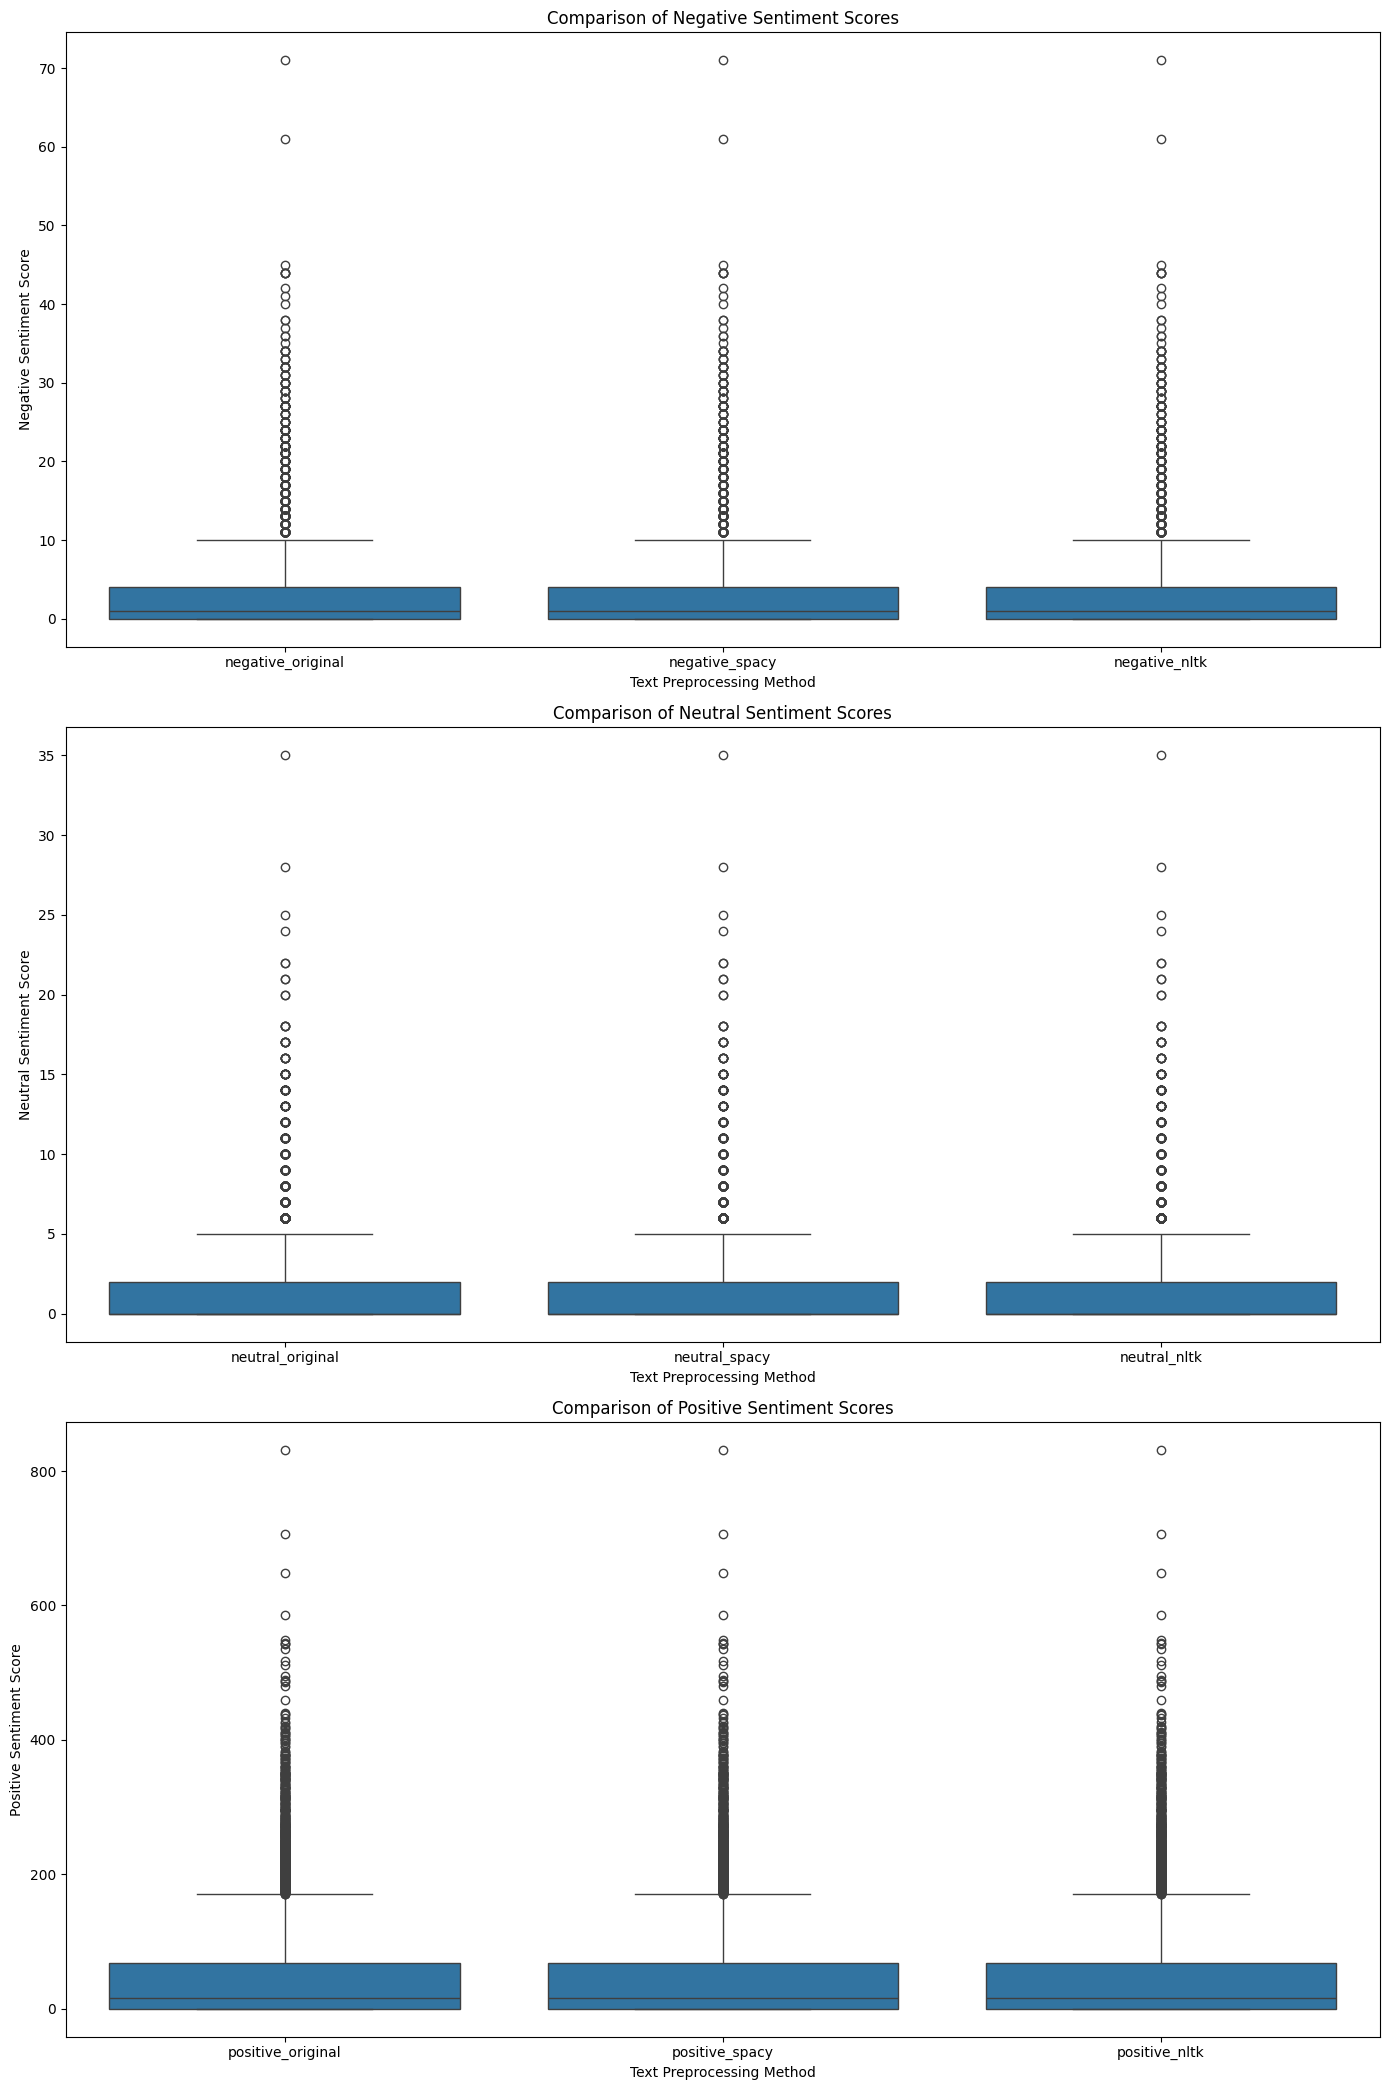

In [65]:
df_combined = df_train_original[['description', 'negative', 'neutral', 'positive']].rename(
    columns={'negative': 'negative_original', 'neutral': 'neutral_original', 'positive': 'positive_original'})

df_combined = df_combined.merge(
    df_train_spacy[['description_preprocessed', 'negative', 'neutral', 'positive']].rename(
        columns={'negative': 'negative_spacy', 'neutral': 'neutral_spacy', 'positive': 'positive_spacy'}),
    left_index=True, right_index=True)

df_combined = df_combined.merge(
    df_train_nltk[['description_cleaned_nltk', 'negative', 'neutral', 'positive']].rename(
        columns={'negative': 'negative_nltk', 'neutral': 'neutral_nltk', 'positive': 'positive_nltk'}),
    left_index=True, right_index=True)

sentiment_cols = ['negative', 'neutral', 'positive']

fig, axes = plt.subplots(3, 1, figsize=(14, 21))
for i, col in enumerate(sentiment_cols):
    sns.boxplot(data=df_combined[[f'{col}_original', f'{col}_spacy', f'{col}_nltk']].melt(), 
                x='variable', y='value', ax=axes[i])
    axes[i].set_title(f'Comparison of {col.capitalize()} Sentiment Scores')
    axes[i].set_xlabel('Text Preprocessing Method')
    axes[i].set_ylabel(f'{col.capitalize()} Sentiment Score')
plt.tight_layout()
plt.show()

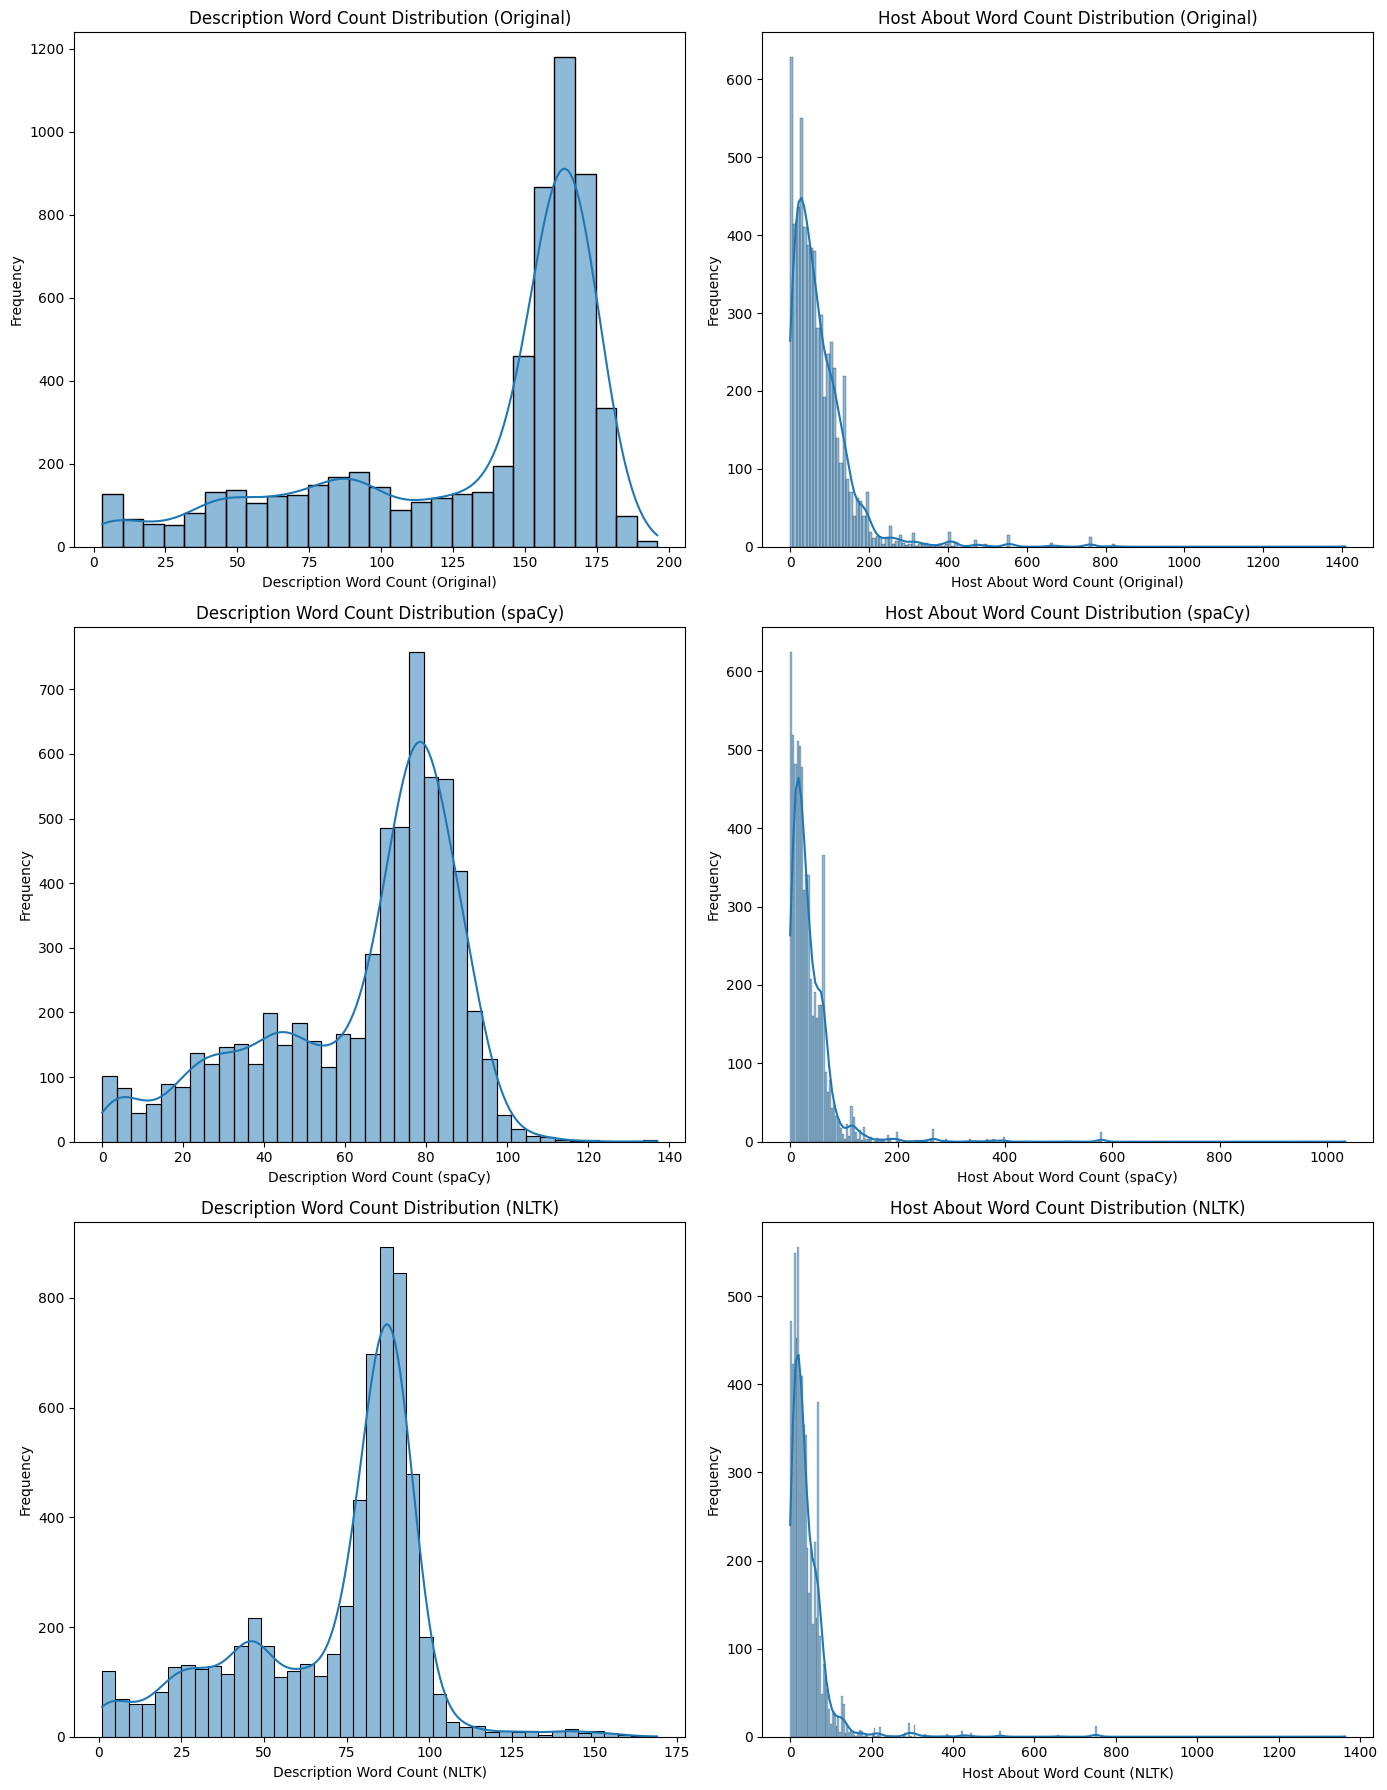

In [66]:
df_train_original1 = df_train_original.copy()
df_train_spacy1 = df_train_spacy.copy()
df_train_nltk1 = df_train_nltk.copy()

# Calculate word counts for each dataset
df_train_original1['description_word_count_original'] = df_train_original1['description'].apply(lambda x: len(str(x).split()))
df_train_original1['host_about_word_count_original'] = df_train_original1['host_about'].apply(lambda x: len(str(x).split()))

df_train_spacy1['description_word_count_spacy'] = df_train_spacy1['description_preprocessed'].apply(lambda x: len(str(x).split()))
df_train_spacy1['host_about_word_count_spacy'] = df_train_spacy1['host_about_preprocessed'].apply(lambda x: len(str(x).split()))

df_train_nltk1['description_word_count_nltk'] = df_train_nltk1['description_cleaned_nltk'].apply(lambda x: len(str(x).split()))
df_train_nltk1['host_about_word_count_nltk'] = df_train_nltk1['host_about_cleaned_nltk'].apply(lambda x: len(str(x).split()))

# Create a grid of plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

# Plot for description_word_count
sns.histplot(df_train_original1['description_word_count_original'], ax=axes[0, 0], kde=True)
axes[0, 0].set_xlabel('Description Word Count (Original)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Description Word Count Distribution (Original)')

sns.histplot(df_train_spacy1['description_word_count_spacy'], ax=axes[1, 0], kde=True)
axes[1, 0].set_xlabel('Description Word Count (spaCy)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Description Word Count Distribution (spaCy)')

sns.histplot(df_train_nltk1['description_word_count_nltk'], ax=axes[2, 0], kde=True)
axes[2, 0].set_xlabel('Description Word Count (NLTK)')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_title('Description Word Count Distribution (NLTK)')

# Plot for host_about_word_count
sns.histplot(df_train_original1['host_about_word_count_original'], ax=axes[0, 1], kde=True)
axes[0, 1].set_xlabel('Host About Word Count (Original)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Host About Word Count Distribution (Original)')

sns.histplot(df_train_spacy1['host_about_word_count_spacy'], ax=axes[1, 1], kde=True)
axes[1, 1].set_xlabel('Host About Word Count (spaCy)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Host About Word Count Distribution (spaCy)')

sns.histplot(df_train_nltk1['host_about_word_count_nltk'], ax=axes[2, 1], kde=True)
axes[2, 1].set_xlabel('Host About Word Count (NLTK)')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_title('Host About Word Count Distribution (NLTK)')

plt.tight_layout()
plt.show()

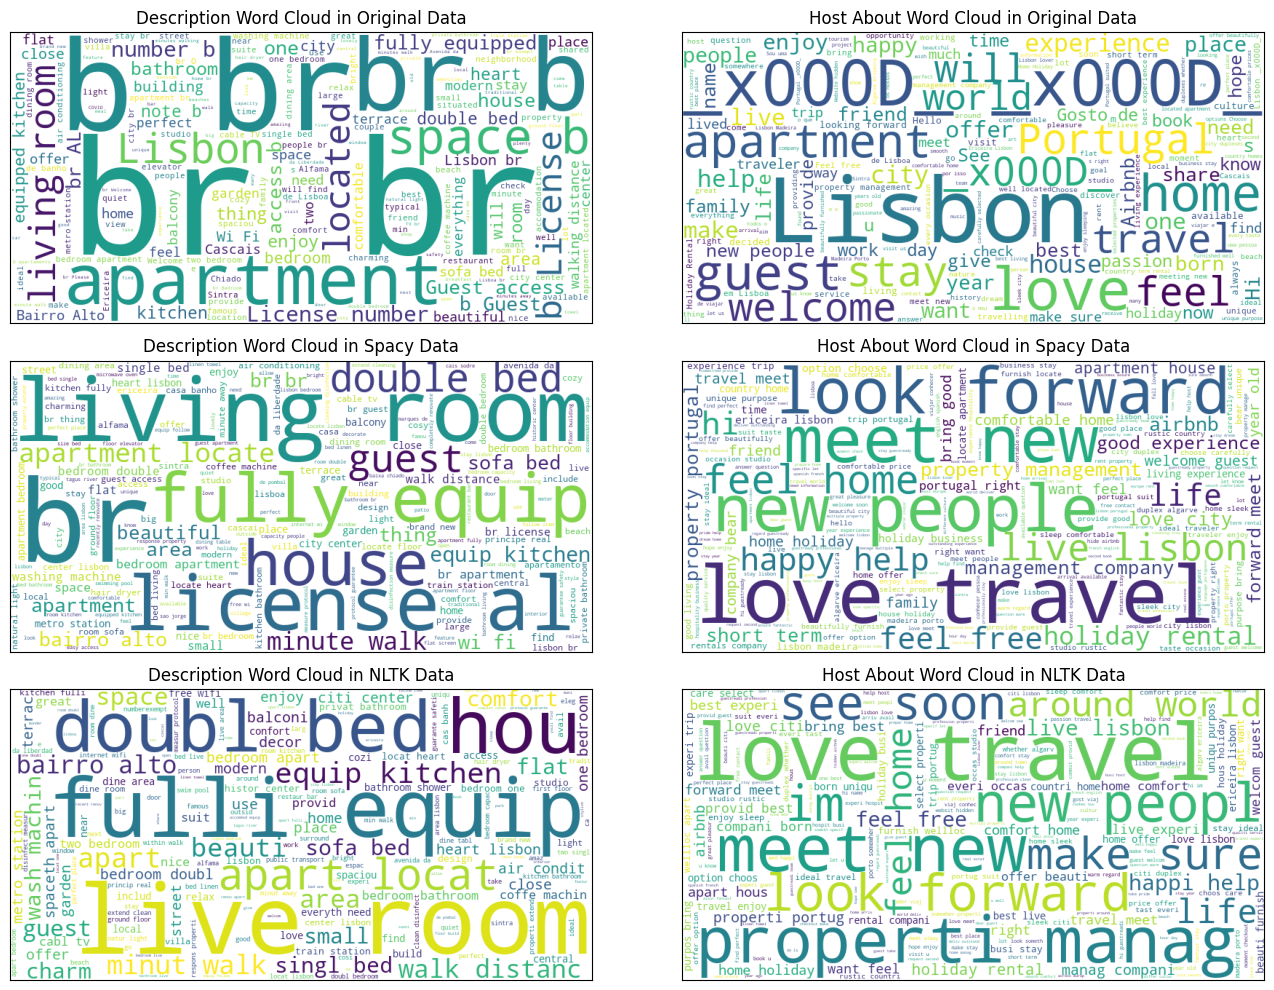

In [67]:
# Joining all the texts into single strings
all_descriptions = ' '.join(df_train_original['description'])
all_host_abouts= ' '.join(df_train_original['host_about'])
all_descriptions1 = ' '.join(df_train_spacy['description_preprocessed'])
all_host_abouts1= ' '.join(df_train_spacy['host_about_preprocessed'])
all_descriptions2 = ' '.join(df_train_nltk['description_cleaned_nltk'])
all_host_abouts2= ' '.join(df_train_nltk['host_about_cleaned_nltk'])
    
def generate_wordcloud(text_data, title, ax): 
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)
    ax.imshow(wordcloud)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

generate_wordcloud(all_descriptions, 'Description Word Cloud in Original Data', axes[0,0])
generate_wordcloud(all_host_abouts, 'Host About Word Cloud in Original Data', axes[0,1])
generate_wordcloud(all_descriptions1, 'Description Word Cloud in Spacy Data', axes[1,0])
generate_wordcloud(all_host_abouts1, 'Host About Word Cloud in Spacy Data', axes[1,1])
generate_wordcloud(all_descriptions2, 'Description Word Cloud in NLTK Data', axes[2,0])
generate_wordcloud(all_host_abouts2, 'Host About Word Cloud in NLTK Data', axes[2,1])

plt.tight_layout()
plt.show()

# **FEATURE ENGINEERING**

## Bag Of Words

### With NLTK

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

bow = CountVectorizer(binary=True)

X_text_train = df_train_nltk[['description_cleaned_nltk', 'host_about_cleaned_nltk']]
X_numerical_train = df_train_nltk[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_bow_nltk = df_train_nltk['unlisted']

X_text_train_bow = bow.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))
X_train_bow_nltk = hstack([X_text_train_bow, X_numerical_train])

### With SpaCy

In [69]:
bow = CountVectorizer(binary=True)

X_text_train = df_train_spacy[['description_preprocessed', 'host_about_preprocessed']]
X_numerical_train = df_train_spacy[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_bow_spacy = df_train_spacy['unlisted']

X_text_train_bow = bow.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))
X_train_bow_spacy = hstack([X_text_train_bow, X_numerical_train])

## TF-IDF

### With NLTK

#### Unigram

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_ug = TfidfVectorizer()

X_text_train = df_train_nltk[['description_cleaned_nltk', 'host_about_cleaned_nltk']]
X_numerical_train = df_train_nltk[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_tfidf_ug_nltk = df_train_nltk['unlisted']

X_text_train_tfidf_ug = tfidf_ug.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_train_tfidf_ug_nltk = hstack([X_text_train_tfidf_ug, X_numerical_train])

In [71]:
df = pd.DataFrame(X_text_train_tfidf_ug[0].T.todense(), index=tfidf_ug.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

             TF-IDF
room       0.406880
mix        0.261477
keycard    0.217129
curfew     0.217129
lateguest  0.217129
access     0.191660
bathroomw  0.186840
squareth   0.169402
blanket    0.168175
registr    0.167004
woman      0.161852
lamp       0.160054
gather     0.159202
guest      0.153724
marqu      0.144414
spacew     0.143499
share      0.136449
accessal   0.131563
hostel     0.129421
standard   0.120810
twin       0.118050
pombal     0.115269
aloj       0.114834
side       0.112502
late       0.110609


#### Bigram

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_bg = TfidfVectorizer(max_df=0.8, ngram_range=(1, 2))

X_text_train = df_train_nltk[['description_cleaned_nltk', 'host_about_cleaned_nltk']]
X_numerical_train = df_train_nltk[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_tfidf_bg_nltk = df_train_nltk['unlisted']

X_text_train_tfidf_bg = tfidf_bg.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_train_tfidf_bg_nltk = hstack([X_text_train_tfidf_bg, X_numerical_train])

#### Trigram

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_tg = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))

X_text_train = df_train_nltk[['description_cleaned_nltk', 'host_about_cleaned_nltk']]
X_numerical_train = df_train_nltk[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_tfidf_tg_nltk = df_train_nltk['unlisted']

X_text_train_tfidf_tg = tfidf_tg.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_train_tfidf_tg_nltk = hstack([X_text_train_tfidf_tg, X_numerical_train])

### With SpaCy

#### Unigram

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_ug = TfidfVectorizer()

X_text_train = df_train_spacy[['description_preprocessed', 'host_about_preprocessed']]
X_numerical_train = df_train_spacy[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_tfidf_ug_spacy = df_train_spacy['unlisted']

X_text_train_tfidf_ug = tfidf_ug.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_train_tfidf_ug_spacy = hstack([X_text_train_tfidf_ug, X_numerical_train])

#### Bigram

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_bg = TfidfVectorizer(max_df=0.8, ngram_range=(1, 2))

X_text_train = df_train_spacy[['description_preprocessed', 'host_about_preprocessed']]
X_numerical_train = df_train_spacy[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_tfidf_bg_spacy = df_train_spacy['unlisted']

X_text_train_tfidf_bg = tfidf_bg.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_train_tfidf_bg_spacy = hstack([X_text_train_tfidf_bg, X_numerical_train])

#### Trigram

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_tg_spacy = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))

X_text_train = df_train_spacy[['description_preprocessed', 'host_about_preprocessed']]
X_numerical_train = df_train_spacy[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]
y_train_tfidf_tg_spacy = df_train_spacy['unlisted']

X_text_train_tfidf_tg = tfidf_tg_spacy.fit_transform(X_text_train.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_train_tfidf_tg_spacy = hstack([X_text_train_tfidf_tg, X_numerical_train])

## Word2Vec

### With NLTK

In [3]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.downloader
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load pre-trained Word2Vec embeddings using Gensim downloader
embedding_model = gensim.downloader.load('word2vec-google-news-300')

# Tokenization and embedding lookup function
def embed_text(text, embedding_model, embedding_dim):
    tokens = word_tokenize(text)  # Tokenize text and convert to lowercase
    embeddings = []
    for token in tokens:
        if token in embedding_model.key_to_index:
            embeddings.append(embedding_model[token])
    # Ensure all embeddings have the same dimension
    if embeddings:
        return np.array(embeddings)
    else:
        return np.zeros((1, embedding_dim))  # Return zero vector if no valid embeddings found

# Embedding dimension for the Word2Vec model
embedding_dim_w2v = 300

df_train_w2v_nltk = df_train_nltk.copy()

# Apply tokenization and embedding lookup to 'host_about' and 'description' features for train dataset
df_train_w2v_nltk['host_about_embeddings'] = df_train_w2v_nltk['host_about_cleaned_nltk'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_w2v))
df_train_w2v_nltk['description_embeddings'] = df_train_w2v_nltk['description_cleaned_nltk'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_w2v))

# Pad sequences to ensure uniform length
max_desc_len_w2v_nltk = max(df_train_w2v_nltk['description_embeddings'].apply(len))
max_host_len_w2v_nltk = max(df_train_w2v_nltk['host_about_embeddings'].apply(len))

description_embeddings_w2v_nltk = pad_sequences(df_train_w2v_nltk['description_embeddings'].tolist(), maxlen=max_desc_len_w2v_nltk, padding='post', dtype='float32')
host_about_embeddings_w2v_nltk = pad_sequences(df_train_w2v_nltk['host_about_embeddings'].tolist(), maxlen=max_host_len_w2v_nltk, padding='post', dtype='float32')

numerical_features_nltk = df_train_w2v_nltk[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]

### With SpaCy

In [4]:
df_train_w2v_spacy = df_train_spacy.copy()

# Apply tokenization and embedding lookup to 'host_about' and 'description' features for train dataset
df_train_w2v_spacy['host_about_embeddings'] = df_train_w2v_spacy['host_about_preprocessed'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_w2v))
df_train_w2v_spacy['description_embeddings'] = df_train_w2v_spacy['description_preprocessed'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_w2v))

# Pad sequences to ensure uniform length
max_desc_len_w2v_spacy = max(df_train_w2v_spacy['description_embeddings'].apply(len))
max_host_len_w2v_spacy = max(df_train_w2v_spacy['host_about_embeddings'].apply(len))

description_embeddings_w2v_spacy = pad_sequences(df_train_w2v_spacy['description_embeddings'].tolist(), maxlen=max_desc_len_w2v_spacy, padding='post', dtype='float32')
host_about_embeddings_w2v_spacy = pad_sequences(df_train_w2v_spacy['host_about_embeddings'].tolist(), maxlen=max_host_len_w2v_spacy, padding='post', dtype='float32')

numerical_features_spacy = df_train_w2v_spacy[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]


## GloVe

### With NLTK

In [5]:
# Load pre-trained GloVe Twitter embeddings using Gensim downloader
embedding_model = gensim.downloader.load('glove-twitter-100')

# Embedding dimension for the GloVe Twitter model
embedding_dim_glove = 100

df_train_glove_nltk = df_train_nltk.copy()

# Apply tokenization and embedding lookup to 'host_about' and 'description' features for train dataset
df_train_glove_nltk['host_about_embeddings'] = df_train_glove_nltk['host_about_cleaned_nltk'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_glove))
df_train_glove_nltk['description_embeddings'] = df_train_glove_nltk['description_cleaned_nltk'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_glove))

# Pad sequences to ensure uniform length
max_desc_len_glove_nltk = max(df_train_glove_nltk['description_embeddings'].apply(len))
max_host_len_glove_nltk = max(df_train_glove_nltk['host_about_embeddings'].apply(len))

description_embeddings_glove_nltk = pad_sequences(df_train_glove_nltk['description_embeddings'].tolist(), maxlen=max_desc_len_glove_nltk, padding='post', dtype='float32')
host_about_embeddings_glove_nltk = pad_sequences(df_train_glove_nltk['host_about_embeddings'].tolist(), maxlen=max_host_len_glove_nltk, padding='post', dtype='float32')


### With SpaCy

In [6]:
df_train_glove_spacy = df_train_spacy.copy()

# Apply tokenization and embedding lookup to 'host_about' and 'description' features for train dataset
df_train_glove_spacy['host_about_embeddings'] = df_train_glove_spacy['host_about_preprocessed'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_glove))
df_train_glove_spacy['description_embeddings'] = df_train_glove_spacy['description_preprocessed'].apply(lambda x: embed_text(x, embedding_model, embedding_dim_glove))

# Pad sequences to ensure uniform length
max_desc_len_glove_spacy = max(df_train_glove_spacy['description_embeddings'].apply(len))
max_host_len_glove_spacy = max(df_train_glove_spacy['host_about_embeddings'].apply(len))

description_embeddings_glove_spacy = pad_sequences(df_train_glove_spacy['description_embeddings'].tolist(), maxlen=max_desc_len_glove_spacy, padding='post', dtype='float32')
host_about_embeddings_glove_spacy = pad_sequences(df_train_glove_spacy['host_about_embeddings'].tolist(), maxlen=max_host_len_glove_spacy, padding='post', dtype='float32')


## Transformer-based embeddings

### XLM-RoBERTa

Here we will also use the description and host without being cleaned before, because the transformer is designed to handle raw text effectively

In [12]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from tqdm import tqdm

# Load the DataFrame
# Assuming df_train contains your DataFrame with 'description' and 'host_about' columns

# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to embed text using XLM-RoBERTa
def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling of token embeddings
    return embeddings.cpu().numpy()

# Add progress bar
tqdm.pandas()

df_train_roberta = df_train_original[['description', 'host_about', 'unlisted', 'reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]

# Embed 'description' column
df_train_roberta['description_embeddings'] = df_train_roberta['description'].progress_apply(embed_text)

# Embed 'host_about' column
df_train_roberta['host_about_embeddings'] = df_train_roberta['host_about'].progress_apply(embed_text)

# Drop 'description' and 'host_about' columns
df_train_roberta.drop(columns=['description', 'host_about'], inplace=True)

# Display the DataFrame
df_train_roberta

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 6248/6248 [03:10<00:00, 32.82it/s]
C:\Users\Filipe\AppData\Local\Temp\ipykernel_8944\876131079.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

unlisted  reviews_exist  negative  neutral  positive  reviews  \
0            0              1       4.0      4.0      42.0     50.0   
1            1              0       0.0      0.0       0.0      0.0   
2            1              0       0.0      0.0       0.0      0.0   
3            0              0       0.0      0.0       0.0      0.0   
4            0              1       0.0      0.0      41.0     41.0   
...        ...            ...       ...      ...       ...      ...   
6243         0              1       2.0      1.0      97.0    100.0   
6244         0              1       4.0      2.0     124.0    130.0   
6245         1              1       1.0      2.0      22.0     25.0   
6246         0              1       3.0      1.0      21.0     25.0   
6247         0              1      13.0     11.0     251.0    275.0   

                                 description_embeddings  \
0     [[0.002810027, 0.008393644, 0.011944802, -0.01...   
1     [[0.0036332859, 0.008318468, 0.02192195, 0.010...   
2     [[0.019604104, 0.0015990107, -0.0068635214, 0....   
3     [[0.021047102, 0.006872028, 0.0014382544, 0.01...   
4     [[0.02071376, 0.031511627, 0.0082431175, -0.03...   
...                                                 ...   
6243  [[0.021781938, 0.03417867, 0.00046510535, -0.0...   
6244  [[0.0043000076, 0.01271162, -9.651476e-05, -0....   
6245  [[-0.020573858, 0.015511874, -0.02946547, 0.01...   
6246  [[0.0041274335, 0.00934035, -0.0029967085, -0....   
6247  [[0.00621898, 0.01453175, 0.0022495058, -0.016...   

                                  host_about_embeddings  
0     [[0.015385981, 0.037158586, 0.024526259, -0.01...  
1     [[-0.017450001, 0.044748567, 0.020681426, 0.02...  
2     [[-0.009800918, 0.03887823, -0.0072831954, -0....  
3     [[-0.017244004, 0.033962157, -0.0012157179, 0....  
4     [[-0.004607448, -0.024545714, 0.015738329, 0.0...  
...                                                 ...  
6243  [[-0.0045501343, 0.04895027, 0.0002435249, 0.0...  
6244  [[0.013352847, 0.02203361, -0.0076904222, -0.0...  
6245  [[-0.028817816, 0.039652392, 0.027142141, 0.00...  
6246  [[0.028255401, 0.071013525, -0.032427453, -0.0...  
6247  [[-0.0052242735, -0.019706337, 0.015558412, -0...  

[6248 rows x 8 columns]

### Voyage

In [19]:
import torch
import voyageai
from tqdm import tqdm

# Set your Voyage AI API key
voyageai.api_key = "pa-IosfUg26JSj7F6lIcldSVBTpopwHojwhE0t9Q3TkbWA"

# Initialize the Voyage AI client
vo = voyageai.Client()

# Function to embed text using Voyage AI
def embed_text_voyage(text):
    result = vo.embed([text], model="voyage-large-2-instruct", input_type="document")
    return result.embeddings

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_train_voyage =  df_train_original[['description', 'host_about', 'unlisted', 'reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]

# Add progress bar
tqdm.pandas()

# Embed 'description' column
df_train_voyage['description_embeddings'] = df_train_voyage['description'].progress_apply(embed_text_voyage)

# Embed 'host_about' column
df_train_voyage['host_about_embeddings'] = df_train_voyage['host_about'].progress_apply(embed_text_voyage)

# Drop 'description' and 'host_about' columns
df_train_voyage.drop(columns=['description', 'host_about'], inplace=True)

# Display the DataFrame
df_train_voyage

100%|██████████| 6248/6248 [36:20<00:00,  2.87it/s]
C:\Users\Filipe\AppData\Local\Temp\ipykernel_8944\2193134676.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_voyage['description_embeddings'] = df_train_voyage['description'].progress_apply(embed_text_voyage)
100%|██████████| 6248/6248 [36:16<00:00,  2.87it/s]


unlisted  reviews_exist  negative  neutral  positive  reviews  \
0            0              1       4.0      4.0      42.0     50.0   
1            1              0       0.0      0.0       0.0      0.0   
2            1              0       0.0      0.0       0.0      0.0   
3            0              0       0.0      0.0       0.0      0.0   
4            0              1       0.0      0.0      41.0     41.0   
...        ...            ...       ...      ...       ...      ...   
6243         0              1       2.0      1.0      97.0    100.0   
6244         0              1       4.0      2.0     124.0    130.0   
6245         1              1       1.0      2.0      22.0     25.0   
6246         0              1       3.0      1.0      21.0     25.0   
6247         0              1      13.0     11.0     251.0    275.0   

                                 description_embeddings  \
0     [[0.011290371417999268, 0.043476976454257965, ...   
1     [[0.008351576514542103, 0.016851112246513367, ...   
2     [[0.011518249288201332, 0.035362448543310165, ...   
3     [[0.018274253234267235, 0.07388841360807419, -...   
4     [[0.003220156766474247, 0.029153093695640564, ...   
...                                                 ...   
6243  [[0.034156810492277145, 0.05633111298084259, -...   
6244  [[0.02386537194252014, 0.07444800436496735, -0...   
6245  [[0.030540065839886665, 0.026030754670500755, ...   
6246  [[0.010592465288937092, 0.05490895360708237, -...   
6247  [[0.019131070002913475, 0.047021545469760895, ...   

                                  host_about_embeddings  
0     [[0.0028526545502245426, 0.04082009568810463, ...  
1     [[0.008522631600499153, 0.0006853724480606616,...  
2     [[0.004341076593846083, 0.02737683616578579, -...  
3     [[0.04334690049290657, 0.035338371992111206, -...  
4     [[0.03387242555618286, 0.005589060019701719, -...  
...                                                 ...  
6243  [[0.02300005778670311, -0.015363152138888836, ...  
6244  [[0.03868429735302925, 0.03764631226658821, -0...  
6245  [[0.01122836023569107, -0.006390863563865423, ...  
6246  [[0.014097287319600582, -0.002858541440218687,...  
6247  [[0.007795032579451799, 0.0005381778464652598,...  

[6248 rows x 8 columns]

# **CLASSIFICATION MODELS**

We have the following data for each feature engineering method:

BoW
* X_train_bow_nltk, y_train_bow_nltk
* X_train_bow_spacy, y_train_bow_spacy

TFIDF
* X_train_tfidf_ug_nltk, y_train_tfidf_ug_nltk
* X_train_tfidf_ug_spacy, y_train_tfidf_ug_spacy
* X_train_tfidf_bg_nltk, y_train_tfidf_bg_nltk
* X_train_tfidf_bg_spacy, y_train_tfidf_bg_spacy
* X_train_tfidf_tg_nltk, y_train_tfidf_tg_nltk
* X_train_tfidf_tg_spacy, y_train_tfidf_tg_spacy

Word2Vec
* df_train_w2v_nltk
* df_train_w2v_spacy 

GloVe
* df_train_glove_nltk
* df_train_glove_spacy

XLM-RoBERTa
* df_train_roberta

Voyage
* df_train_voyage

## LogisticRegression

### BoW

#### NLTK

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(X_train_bow_nltk, y_train_bow_nltk, test_size=0.2, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       890
           1       0.78      0.78      0.78       347

    accuracy                           0.88      1237
   macro avg       0.85      0.85      0.85      1237
weighted avg       0.88      0.88      0.88      1237

Confusion Matrix:
[[813  77]
 [ 76 271]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### SpaCy

In [84]:
X_train, X_val, y_train, y_val = train_test_split(X_train_bow_spacy, y_train_bow_spacy, test_size=0.2, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       905
           1       0.76      0.79      0.77       345

    accuracy                           0.87      1250
   macro avg       0.84      0.85      0.84      1250
weighted avg       0.87      0.87      0.87      1250

Confusion Matrix:
[[817  88]
 [ 73 272]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### TFIDF

#### NLTK

In [85]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_ug_nltk, y_train_tfidf_ug_nltk, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       890
           1       0.76      0.85      0.80       347

    accuracy                           0.88      1237
   macro avg       0.85      0.87      0.86      1237
weighted avg       0.89      0.88      0.89      1237

Confusion Matrix:
[[799  91]
 [ 53 294]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_bg_nltk, y_train_tfidf_bg_nltk, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       890
           1       0.77      0.85      0.81       347

    accuracy                           0.89      1237
   macro avg       0.85      0.87      0.86      1237
weighted avg       0.89      0.89      0.89      1237

Confusion Matrix:
[[800  90]
 [ 52 295]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [160]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_tg_nltk, y_train_tfidf_tg_nltk, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       890
           1       0.77      0.85      0.81       347

    accuracy                           0.89      1237
   macro avg       0.85      0.88      0.86      1237
weighted avg       0.89      0.89      0.89      1237

Confusion Matrix:
[[800  90]
 [ 51 296]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### SpaCy

In [88]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_ug_spacy, y_train_tfidf_ug_spacy, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       905
           1       0.75      0.86      0.81       345

    accuracy                           0.88      1250
   macro avg       0.85      0.88      0.86      1250
weighted avg       0.89      0.88      0.89      1250

Confusion Matrix:
[[808  97]
 [ 47 298]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_bg_spacy, y_train_tfidf_bg_spacy, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       905
           1       0.75      0.87      0.81       345

    accuracy                           0.88      1250
   macro avg       0.85      0.88      0.86      1250
weighted avg       0.89      0.88      0.89      1250

Confusion Matrix:
[[806  99]
 [ 45 300]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [174]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_tg_spacy, y_train_tfidf_tg_spacy, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       905
           1       0.76      0.87      0.81       345

    accuracy                           0.89      1250
   macro avg       0.85      0.88      0.87      1250
weighted avg       0.90      0.89      0.89      1250

Confusion Matrix:
[[809  96]
 [ 44 301]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Word2Vec

#### NLTK

In [9]:
# Flatten or reshape the embedding features
description_embeddings_flat = description_embeddings_w2v_nltk.reshape(len(description_embeddings_w2v_nltk), -1)
host_about_embeddings_flat = host_about_embeddings_w2v_nltk.reshape(len(host_about_embeddings_w2v_nltk), -1)

# Concatenate numerical and flattened embedding features
X = np.concatenate([numerical_features_nltk.values, description_embeddings_flat, host_about_embeddings_flat], axis=1)
y = df_train_w2v_nltk['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       890
           1       0.78      0.67      0.72       347

    accuracy                           0.86      1237
   macro avg       0.83      0.80      0.81      1237
weighted avg       0.85      0.86      0.85      1237

Confusion Matrix:
[[825  65]
 [113 234]]


#### SpaCy

In [8]:
# Flatten or reshape the embedding features
description_embeddings_flat = description_embeddings_w2v_spacy.reshape(len(description_embeddings_w2v_spacy), -1)
host_about_embeddings_flat = host_about_embeddings_w2v_spacy.reshape(len(host_about_embeddings_w2v_spacy), -1)

# Concatenate numerical and flattened embedding features
X = np.concatenate([numerical_features_spacy.values, description_embeddings_flat, host_about_embeddings_flat], axis=1)
y = df_train_w2v_spacy['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       905
           1       0.74      0.66      0.70       345

    accuracy                           0.84      1250
   macro avg       0.81      0.79      0.80      1250
weighted avg       0.84      0.84      0.84      1250

Confusion Matrix:
[[826  79]
 [118 227]]


### GloVe

#### NLTK

In [9]:
# Flatten or reshape the embedding features
description_embeddings_flat = description_embeddings_glove_nltk.reshape(len(description_embeddings_glove_nltk), -1)
host_about_embeddings_flat = host_about_embeddings_glove_nltk.reshape(len(host_about_embeddings_glove_nltk), -1)

# Concatenate numerical and flattened embedding features
X = np.concatenate([numerical_features_nltk.values, description_embeddings_flat, host_about_embeddings_flat], axis=1)
y = df_train_glove_nltk['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       890
           1       0.70      0.58      0.64       347

    accuracy                           0.81      1237
   macro avg       0.78      0.74      0.76      1237
weighted avg       0.81      0.81      0.81      1237

Confusion Matrix:
[[805  85]
 [145 202]]


#### SpaCy

In [10]:
# Flatten or reshape the embedding features
description_embeddings_flat = description_embeddings_glove_spacy.reshape(len(description_embeddings_glove_spacy), -1)
host_about_embeddings_flat = host_about_embeddings_glove_spacy.reshape(len(host_about_embeddings_glove_spacy), -1)

# Concatenate numerical and flattened embedding features
X = np.concatenate([numerical_features_spacy.values, description_embeddings_flat, host_about_embeddings_flat], axis=1)
y = df_train_glove_spacy['unlisted']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       905
           1       0.71      0.65      0.68       345

    accuracy                           0.83      1250
   macro avg       0.79      0.77      0.78      1250
weighted avg       0.83      0.83      0.83      1250

Confusion Matrix:
[[811  94]
 [120 225]]


### XLM-RoBERTa

In [95]:
# Extract embedding features
description_embeddings = np.array(df_train_roberta['description_embeddings'].tolist())
host_about_embeddings = np.array(df_train_roberta['host_about_embeddings'].tolist())

numerical_features = df_train_roberta[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]

# Flatten or reshape the embedding features
description_embeddings_flat = description_embeddings.reshape(len(description_embeddings), -1)
host_about_embeddings_flat = host_about_embeddings.reshape(len(host_about_embeddings), -1)

# Concatenate numerical and flattened embedding features
X = np.concatenate([numerical_features, description_embeddings_flat, host_about_embeddings_flat], axis=1)
y = df_train_roberta['unlisted']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       905
           1       0.76      0.85      0.80       345

    accuracy                           0.88      1250
   macro avg       0.85      0.87      0.86      1250
weighted avg       0.89      0.88      0.89      1250

Confusion Matrix:
[[813  92]
 [ 53 292]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Voyage

In [97]:
# Extract embedding features
description_embeddings = np.array(df_train_voyage['description_embeddings'].tolist())
host_about_embeddings = np.array(df_train_voyage['host_about_embeddings'].tolist())

numerical_features = df_train_voyage[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]

# Flatten or reshape the embedding features
description_embeddings_flat = description_embeddings.reshape(len(description_embeddings), -1)
host_about_embeddings_flat = host_about_embeddings.reshape(len(host_about_embeddings), -1)

# Concatenate numerical and flattened embedding features
X = np.concatenate([numerical_features, description_embeddings_flat, host_about_embeddings_flat], axis=1)
y = df_train_voyage['unlisted']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       905
           1       0.76      0.85      0.80       345

    accuracy                           0.89      1250
   macro avg       0.85      0.87      0.86      1250
weighted avg       0.89      0.89      0.89      1250

Confusion Matrix:
[[814  91]
 [ 52 293]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## MLP

### BoW

#### NLTK

In [122]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_bow_nltk, y_train_bow_nltk, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 33686)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │     2,155,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,162,241 (8.25 MB)

 Trainable params: 2,162,241 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8308 - loss: 0.4237 - val_accuracy: 0.8723 - val_loss: 0.3465
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9313 - loss: 0.2091 - val_accuracy: 0.8779 - val_loss: 0.3888
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9599 - loss: 0.1193 - val_accuracy: 0.8852 - val_loss: 0.4727
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9753 - loss: 0.0723 - val_accuracy: 0.8787 - val_loss: 0.5379
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9857 - loss: 0.0436 - val_accuracy: 0.8771 - val_loss: 0.6706
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9888 - loss: 0.0324 - val_accuracy: 0.8787 - val_loss: 0.6524
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9919 - loss: 0.0227 - val_accuracy: 0.8569 - val_loss: 0.7017
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9912 - loss: 0.0298 - val_accu

#### SpaCy

In [123]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_bow_spacy, y_train_bow_spacy, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 21069)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │     1,348,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,753 (5.17 MB)

 Trainable params: 1,354,753 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8331 - loss: 0.4501 - val_accuracy: 0.8744 - val_loss: 0.3113
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9265 - loss: 0.2250 - val_accuracy: 0.8696 - val_loss: 0.3485
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9487 - loss: 0.1458 - val_accuracy: 0.8728 - val_loss: 0.4482
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9690 - loss: 0.0944 - val_accuracy: 0.8728 - val_loss: 0.5354
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9817 - loss: 0.0583 - val_accuracy: 0.8728 - val_loss: 0.6291
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9871 - loss: 0.0375 - val_accuracy: 0.8728 - val_loss: 0.6772
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9885 - loss: 0.0353 - val_accuracy: 0.8736 - val_loss: 0.7081
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9886 - loss: 0.0264 - val_accuracy: 0.

### TFIDF

#### NLTK

In [124]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_ug_nltk, y_train_tfidf_ug_nltk, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 33686)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │     2,155,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,162,241 (8.25 MB)

 Trainable params: 2,162,241 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8224 - loss: 0.4425 - val_accuracy: 0.8909 - val_loss: 0.3561
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9146 - loss: 0.2626 - val_accuracy: 0.8965 - val_loss: 0.3215
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9490 - loss: 0.1642 - val_accuracy: 0.8901 - val_loss: 0.3377
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9674 - loss: 0.1171 - val_accuracy: 0.8917 - val_loss: 0.3890
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9720 - loss: 0.0936 - val_accuracy: 0.8933 - val_loss: 0.4379
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9744 - loss: 0.0823 - val_accuracy: 0.8965 - val_loss: 0.5853
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9710 - loss: 0.1114 - val_accuracy: 0.8876 - val_loss: 0.4412
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9806 - loss: 0.0603 - val_accu

In [125]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_bg_nltk, y_train_tfidf_bg_nltk, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 262874)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │    16,824,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,830,273 (64.20 MB)

 Trainable params: 16,830,273 (64.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.8181 - loss: 0.4538 - val_accuracy: 0.8892 - val_loss: 0.3380
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.9358 - loss: 0.2153 - val_accuracy: 0.8901 - val_loss: 0.3253
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.9622 - loss: 0.1254 - val_accuracy: 0.8884 - val_loss: 0.3603
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9822 - loss: 0.0587 - val_accuracy: 0.8852 - val_loss: 0.4112
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.9894 - loss: 0.0374 - val_accuracy: 0.8892 - val_loss: 0.4009
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.9923 - loss: 0.0270 - val_accuracy: 0.8787 - val_loss: 0.4587
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.9855 - loss: 0.0451 - val_accuracy: 0.8812 - val_loss: 0.3916
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.9931 - loss: 0

In [126]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_tg_nltk, y_train_tfidf_tg_nltk, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 630000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │    40,320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,326,337 (153.83 MB)

 Trainable params: 40,326,337 (153.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.8102 - loss: 0.4494 - val_accuracy: 0.8876 - val_loss: 0.3233
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step - accuracy: 0.9460 - loss: 0.1804 - val_accuracy: 0.8892 - val_loss: 0.3547
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.9712 - loss: 0.0851 - val_accuracy: 0.8828 - val_loss: 0.4051
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - accuracy: 0.9879 - loss: 0.0495 - val_accuracy: 0.8820 - val_loss: 0.3715
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.9927 - loss: 0.0266 - val_accuracy: 0.8779 - val_loss: 0.4184
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.9934 - loss: 0.0264 - val_accuracy: 0.8779 - val_loss: 0.4359
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - accuracy: 0.9962 - loss: 0.0105 - val_accuracy: 0.8795 - val_loss: 0.4537
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.9979 - loss: 0

#### SpaCy

In [127]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_ug_spacy, y_train_tfidf_ug_spacy, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 21069)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │     1,348,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,753 (5.17 MB)

 Trainable params: 1,354,753 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8490 - loss: 0.4659 - val_accuracy: 0.8968 - val_loss: 0.3055
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9174 - loss: 0.2663 - val_accuracy: 0.8920 - val_loss: 0.3158
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9501 - loss: 0.1813 - val_accuracy: 0.8808 - val_loss: 0.3642
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9629 - loss: 0.1322 - val_accuracy: 0.8728 - val_loss: 0.4058
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9673 - loss: 0.1130 - val_accuracy: 0.8648 - val_loss: 0.4430
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9701 - loss: 0.1112 - val_accuracy: 0.8664 - val_loss: 0.4906
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9725 - loss: 0.0830 - val_accuracy: 0.8696 - val_loss: 0.5030
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9745 - loss: 0.0807 - val_accuracy: 0.

In [128]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_bg_spacy, y_train_tfidf_bg_spacy, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 213148)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │    13,641,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,647,809 (52.06 MB)

 Trainable params: 13,647,809 (52.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.8470 - loss: 0.4518 - val_accuracy: 0.8976 - val_loss: 0.2958
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9427 - loss: 0.2031 - val_accuracy: 0.8856 - val_loss: 0.3088
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9660 - loss: 0.1149 - val_accuracy: 0.8816 - val_loss: 0.3343
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9739 - loss: 0.1404 - val_accuracy: 0.8824 - val_loss: 0.3593
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9774 - loss: 0.0666 - val_accuracy: 0.8800 - val_loss: 0.3898
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9869 - loss: 0.0362 - val_accuracy: 0.8792 - val_loss: 0.4182
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9899 - loss: 0.0288 - val_accuracy: 0.8728 - val_loss: 0.4639
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9924 - loss: 0.0254 - 

In [129]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import coo_matrix

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_tg_spacy, y_train_tfidf_tg_spacy, test_size=0.2, random_state=42)

# Determine the input shape based on X_train
input_dim = X_train.shape[1]

# Model input for bag-of-words features
input_bow = Input(shape=(input_dim,))
dense_bow = Dense(64, activation='relu')(input_bow)

# Dense layers
dense_layer1 = Dense(64, activation='relu')(dense_bow)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=input_bow, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 535493)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │    34,271,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,277,889 (130.76 MB)

 Trainable params: 34,277,889 (130.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.8331 - loss: 0.4538 - val_accuracy: 0.8960 - val_loss: 0.2922
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9448 - loss: 0.1807 - val_accuracy: 0.8888 - val_loss: 0.3059
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9681 - loss: 0.0993 - val_accuracy: 0.8880 - val_loss: 0.3590
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9834 - loss: 0.0648 - val_accuracy: 0.8832 - val_loss: 0.4259
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.9878 - loss: 0.0526 - val_accuracy: 0.8680 - val_loss: 0.4079
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.9932 - loss: 0.0216 - val_accuracy: 0.8720 - val_loss: 0.5600
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.9920 - loss: 0.0578 - val_accuracy: 0.8736 - val_loss: 0.4484
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.9940 - loss: 0

### Word2Vec

#### NLTK

In [7]:
import numpy as np
import pandas as pd
import gensim.downloader
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Prepare data for model
X_desc = description_embeddings_w2v_nltk
X_host = host_about_embeddings_w2v_nltk
X_numerical = numerical_features_nltk.values
y = df_train_w2v_nltk['unlisted'].values

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

embedding_dim = X_desc_train.shape[2]  # Assuming last dimension is the embedding dimension

# Model input for description embeddings
input_desc = Input(shape=(X_desc_train.shape[1], embedding_dim))
flatten_desc = GlobalAveragePooling1D()(input_desc)
dense_desc = Dense(64, activation='relu')(flatten_desc)

# Model input for host_about embeddings
input_host = Input(shape=(X_host_train.shape[1], embedding_dim))
flatten_host = GlobalAveragePooling1D()(input_host)
dense_host = Dense(64, activation='relu')(flatten_host)

# Numerical features input
input_numerical = Input(shape=(X_numerical_train.shape[1],))
dense_numerical = Dense(64, activation='relu')(input_numerical)

# Concatenate dense layers with numerical features
concatenated_features = Concatenate()([dense_desc, dense_host, dense_numerical])

# Dense layers
dense_layer1 = Dense(64, activation='relu')(concatenated_features)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 129, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 831, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ input_layer[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ input_layer_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     19,264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     19,264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        384 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,377 (208.50 KB)

 Trainable params: 53,377 (208.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8136 - loss: 0.4717 - val_accuracy: 0.8723 - val_loss: 0.3588
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8572 - loss: 0.3886 - val_accuracy: 0.8723 - val_loss: 0.3469
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8705 - loss: 0.3671 - val_accuracy: 0.8715 - val_loss: 0.3916
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8626 - loss: 0.3638 - val_accuracy: 0.8723 - val_loss: 0.3417
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8694 - loss: 0.3447 - val_accuracy: 0.8763 - val_loss: 0.3463
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8738 - loss: 0.3373 - val_accuracy: 0.8779 - val_loss: 0.3376
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8674 - loss: 0.3468 - val_accuracy: 0.8779 - val_loss: 0.3344
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8743 - loss: 0.3288 - val_accuracy: 0

#### SpaCy

In [8]:
# Prepare data for model
X_desc = description_embeddings_w2v_spacy
X_host = host_about_embeddings_w2v_spacy
X_numerical = numerical_features_spacy.values
y = df_train_w2v_spacy['unlisted'].values

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

embedding_dim = X_desc_train.shape[2]  # Assuming last dimension is the embedding dimension

# Model input for description embeddings
input_desc = Input(shape=(X_desc_train.shape[1], embedding_dim))
flatten_desc = GlobalAveragePooling1D()(input_desc)
dense_desc = Dense(64, activation='relu')(flatten_desc)

# Model input for host_about embeddings
input_host = Input(shape=(X_host_train.shape[1], embedding_dim))
flatten_host = GlobalAveragePooling1D()(input_host)
dense_host = Dense(64, activation='relu')(flatten_host)

# Numerical features input
input_numerical = Input(shape=(X_numerical_train.shape[1],))
dense_numerical = Dense(64, activation='relu')(input_numerical)

# Concatenate dense layers with numerical features
concatenated_features = Concatenate()([dense_desc, dense_host, dense_numerical])

# Dense layers
dense_layer1 = Dense(64, activation='relu')(concatenated_features)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 104, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 680, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ input_layer_3[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ input_layer_4[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     19,264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     19,264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        384 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     12,352 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,377 (208.50 KB)

 Trainable params: 53,377 (208.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8514 - loss: 0.4461 - val_accuracy: 0.8704 - val_loss: 0.3680
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8667 - loss: 0.3678 - val_accuracy: 0.8744 - val_loss: 0.3388
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8703 - loss: 0.3389 - val_accuracy: 0.8792 - val_loss: 0.3593
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8759 - loss: 0.3560 - val_accuracy: 0.8784 - val_loss: 0.3490
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8831 - loss: 0.3173 - val_accuracy: 0.8792 - val_loss: 0.3311
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8618 - loss: 0.3507 - val_accuracy: 0.8808 - val_loss: 0.3330
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8738 - loss: 0.3287 - val_accuracy: 0.8744 - val_loss: 0.3539
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8723 - loss: 0.3441 - val_accuracy: 0

### GloVe

#### NLTK

In [9]:
# Prepare data for model
X_desc = description_embeddings_glove_nltk
X_host = host_about_embeddings_glove_nltk
X_numerical = numerical_features_nltk.values
y = df_train_glove_nltk['unlisted'].values

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

embedding_dim = X_desc_train.shape[2]  # Assuming last dimension is the embedding dimension

# Model input for description embeddings
input_desc = Input(shape=(X_desc_train.shape[1], embedding_dim))
flatten_desc = GlobalAveragePooling1D()(input_desc)
dense_desc = Dense(64, activation='relu')(flatten_desc)

# Model input for host_about embeddings
input_host = Input(shape=(X_host_train.shape[1], embedding_dim))
flatten_host = GlobalAveragePooling1D()(input_host)
dense_host = Dense(64, activation='relu')(flatten_host)

# Numerical features input
input_numerical = Input(shape=(X_numerical_train.shape[1],))
dense_numerical = Dense(64, activation='relu')(input_numerical)

# Concatenate dense layers with numerical features
concatenated_features = Concatenate()([dense_desc, dense_host, dense_numerical])

# Dense layers
dense_layer1 = Dense(64, activation='relu')(concatenated_features)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 162, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1274, 100) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ input_layer_6[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ input_layer_7[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      6,464 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      6,464 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │        384 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ dense_13[0][0],   │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     12,352 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,777 (108.50 KB)

 Trainable params: 27,777 (108.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7920 - loss: 0.8998 - val_accuracy: 0.8723 - val_loss: 0.3759
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8627 - loss: 0.3664 - val_accuracy: 0.8723 - val_loss: 0.3548
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8721 - loss: 0.3423 - val_accuracy: 0.8747 - val_loss: 0.3468
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8691 - loss: 0.3421 - val_accuracy: 0.8715 - val_loss: 0.3417
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8711 - loss: 0.3351 - val_accuracy: 0.8763 - val_loss: 0.3486
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8737 - loss: 0.3391 - val_accuracy: 0.8779 - val_loss: 0.3343
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8633 - loss: 0.3552 - val_accuracy: 0.8795 - val_loss: 0.3609
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8763 - loss: 0.3371 - val_accuracy: 0.

#### SpaCy

In [10]:
# Prepare data for model
X_desc = description_embeddings_glove_spacy
X_host = host_about_embeddings_glove_spacy
X_numerical = numerical_features_spacy.values
y = df_train_glove_spacy['unlisted'].values

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

embedding_dim = X_desc_train.shape[2]  # Assuming last dimension is the embedding dimension

# Model input for description embeddings
input_desc = Input(shape=(X_desc_train.shape[1], embedding_dim))
flatten_desc = GlobalAveragePooling1D()(input_desc)
dense_desc = Dense(64, activation='relu')(flatten_desc)

# Model input for host_about embeddings
input_host = Input(shape=(X_host_train.shape[1], embedding_dim))
flatten_host = GlobalAveragePooling1D()(input_host)
dense_host = Dense(64, activation='relu')(flatten_host)

# Numerical features input
input_numerical = Input(shape=(X_numerical_train.shape[1],))
dense_numerical = Dense(64, activation='relu')(input_numerical)

# Concatenate dense layers with numerical features
concatenated_features = Concatenate()([dense_desc, dense_host, dense_numerical])

# Dense layers
dense_layer1 = Dense(64, activation='relu')(concatenated_features)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 127, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 959, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ input_layer_9[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ input_layer_10[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      6,464 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      6,464 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │        384 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 192)       │          0 │ dense_18[0][0],   │
│ (Concatenate)       │                   │            │ dense_19[0][0],   │
│                     │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │     12,352 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         33 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,777 (108.50 KB)

 Trainable params: 27,777 (108.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8008 - loss: 0.7605 - val_accuracy: 0.8704 - val_loss: 0.3477
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8642 - loss: 0.3919 - val_accuracy: 0.8712 - val_loss: 0.3700
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8727 - loss: 0.3512 - val_accuracy: 0.8800 - val_loss: 0.3508
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8794 - loss: 0.3435 - val_accuracy: 0.8736 - val_loss: 0.3518
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8810 - loss: 0.3267 - val_accuracy: 0.8784 - val_loss: 0.3318
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8830 - loss: 0.3242 - val_accuracy: 0.8712 - val_loss: 0.3357
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8782 - loss: 0.3205 - val_accuracy: 0.8816 - val_loss: 0.3298
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8828 - loss: 0.3256 - val_accuracy: 0.

### XLM-RoBERTa

In [102]:
# Prepare data for model
X_desc = np.vstack(df_train_roberta['description_embeddings'].values)
X_host = np.vstack(df_train_roberta['host_about_embeddings'].values)
X_numerical = df_train_roberta[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']].values
y = df_train_roberta['unlisted'].values

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

embedding_dim = X_desc_train.shape[1] 
# Model input for description embeddings
input_desc = Input(shape=(embedding_dim,))
dense_desc = Dense(64, activation='relu')(input_desc)

# Model input for host_about embeddings
input_host = Input(shape=(embedding_dim,))
dense_host = Dense(64, activation='relu')(input_host)

# Numerical features input
input_numerical = Input(shape=(X_numerical_train.shape[1],))
dense_numerical = Dense(64, activation='relu')(input_numerical)

# Concatenate dense layers with numerical features
concatenated_features = Concatenate()([dense_desc, dense_host, dense_numerical])

# Dense layers
dense_layer1 = Dense(64, activation='relu')(concatenated_features)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │     49,216 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │     49,216 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │        384 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 192)       │          0 │ dense_24[0][0],   │
│ (Concatenate)       │                   │            │ dense_25[0][0],   │
│                     │                   │            │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │     12,352 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         33 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,281 (442.50 KB)

 Trainable params: 113,281 (442.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8351 - loss: 0.4173 - val_accuracy: 0.8696 - val_loss: 0.3551
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8671 - loss: 0.3572 - val_accuracy: 0.8776 - val_loss: 0.3362
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8764 - loss: 0.3254 - val_accuracy: 0.8784 - val_loss: 0.3259
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8667 - loss: 0.3285 - val_accuracy: 0.8736 - val_loss: 0.3396
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8791 - loss: 0.3306 - val_accuracy: 0.8848 - val_loss: 0.3110
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8781 - loss: 0.3342 - val_accuracy: 0.8808 - val_loss: 0.3233
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8753 - loss: 0.3161 - val_accuracy: 0.8672 - val_loss: 0.3162
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8802 - loss: 0.3042 - val_accuracy: 0.

### Voyage

In [103]:
# Prepare data for model
X_desc = np.vstack(df_train_voyage['description_embeddings'].values)
X_host = np.vstack(df_train_voyage['host_about_embeddings'].values)
X_numerical = df_train_voyage[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']].values
y = df_train_voyage['unlisted'].values

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

embedding_dim = X_desc_train.shape[1] 

# Model input for description embeddings
input_desc = Input(shape=(embedding_dim,))
dense_desc = Dense(64, activation='relu')(input_desc)

# Model input for host_about embeddings
input_host = Input(shape=(embedding_dim,))
dense_host = Dense(64, activation='relu')(input_host)

# Numerical features input
input_numerical = Input(shape=(X_numerical_train.shape[1],))
dense_numerical = Dense(64, activation='relu')(input_numerical)

# Concatenate dense layers with numerical features
concatenated_features = Concatenate()([dense_desc, dense_host, dense_numerical])

# Dense layers
dense_layer1 = Dense(64, activation='relu')(concatenated_features)
dense_layer2 = Dense(32, activation='relu')(dense_layer1)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer2)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │     65,600 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │     65,600 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │        384 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 192)       │          0 │ dense_30[0][0],   │
│ (Concatenate)       │                   │            │ dense_31[0][0],   │
│                     │                   │            │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │     12,352 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │      2,080 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         33 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 146,049 (570.50 KB)

 Trainable params: 146,049 (570.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8506 - loss: 0.5295 - val_accuracy: 0.8704 - val_loss: 0.3396
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8734 - loss: 0.3453 - val_accuracy: 0.8824 - val_loss: 0.3437
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8713 - loss: 0.3479 - val_accuracy: 0.8816 - val_loss: 0.3242
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.3500 - val_accuracy: 0.8856 - val_loss: 0.3093
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8867 - loss: 0.3094 - val_accuracy: 0.8816 - val_loss: 0.3133
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.3043 - val_accuracy: 0.8840 - val_loss: 0.3081
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8862 - loss: 0.3077 - val_accuracy: 0.8752 - val_loss: 0.3083
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.2787 - val_accuracy: 0.

## LSTM

### Word2Vec

#### NLTK

In [11]:
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Model input for description embeddings
input_desc = Input(shape=(max_desc_len_w2v_nltk, embedding_dim_w2v))
mask_desc = Masking(mask_value=0)(input_desc)
lstm_desc = Bidirectional(LSTM(units=4))(mask_desc)

# Model input for host_about embeddings
input_host = Input(shape=(max_host_len_w2v_nltk, embedding_dim_w2v))
mask_host = Masking(mask_value=0)(input_host)
lstm_host = Bidirectional(LSTM(units=4))(mask_host)

# Numerical features input
input_numerical = Input(shape=(numerical_features_nltk.shape[1],))

# Concatenate LSTM outputs with numerical features
concatenated_features = Concatenate()([lstm_desc, lstm_host, input_numerical])

# Dense layer
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare data for model
X_desc = np.array(description_embeddings_w2v_nltk)
X_host = np.array(host_about_embeddings_w2v_nltk)
X_numerical = numerical_features_nltk.values
y = df_train_w2v_nltk['unlisted']

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 129, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 831, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 129, 300)  │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 831, 300)  │          0 │ input_layer_13[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 129, 300)  │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 129)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 831, 300)  │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 831)       │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 8)         │      9,760 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 8)         │      9,760 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 21)        │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
│                     │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │      1,408 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │         65 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,993 (82.00 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.7625 - loss: 0.5570 - val_accuracy: 0.8723 - val_loss: 0.3562
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 257ms/step - accuracy: 0.8724 - loss: 0.3321 - val_accuracy: 0.8812 - val_loss: 0.3378
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.8839 - loss: 0.3121 - val_accuracy: 0.8804 - val_loss: 0.3335
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 0.8858 - loss: 0.3023 - val_accuracy: 0.8868 - val_loss: 0.3178
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.8912 - loss: 0.2826 - val_accuracy: 0.8892 - val_loss: 0.3167
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.9013 - loss: 0.2884 - val_accuracy: 0.8941 - val_loss: 0.3110
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 0.9043 - loss: 0.2628 - val_accuracy: 0.8828 - val_loss: 0.3173
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.9074 - loss: 0

#### SpaCy

In [12]:
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Model input for description embeddings
input_desc = Input(shape=(max_desc_len_w2v_spacy, embedding_dim_w2v))
mask_desc = Masking(mask_value=0)(input_desc)
lstm_desc = Bidirectional(LSTM(units=4))(mask_desc)

# Model input for host_about embeddings
input_host = Input(shape=(max_host_len_w2v_spacy, embedding_dim_w2v))
mask_host = Masking(mask_value=0)(input_host)
lstm_host = Bidirectional(LSTM(units=4))(mask_host)

# Numerical features input
input_numerical = Input(shape=(numerical_features_spacy.shape[1],))

# Concatenate LSTM outputs with numerical features
concatenated_features = Concatenate()([lstm_desc, lstm_host, input_numerical])

# Dense layer
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare data for model
X_desc = np.array(description_embeddings_w2v_spacy)
X_host = np.array(host_about_embeddings_w2v_spacy)
X_numerical = numerical_features_spacy.values
y = df_train_w2v_spacy['unlisted']

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 104, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 680, 300)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 104, 300)  │          0 │ input_layer_15[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 680, 300)  │          0 │ input_layer_16[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 104, 300)  │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 104)       │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 680, 300)  │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 680)       │          0 │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 8)         │      9,760 │ masking_2[0][0],  │
│ (Bidirectional)     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 8)         │      9,760 │ masking_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 21)        │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
│                     │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      1,408 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1)         │         65 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,993 (82.00 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.7841 - loss: 0.5189 - val_accuracy: 0.8704 - val_loss: 0.3346
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.8701 - loss: 0.3446 - val_accuracy: 0.8824 - val_loss: 0.3280
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.8801 - loss: 0.3240 - val_accuracy: 0.8840 - val_loss: 0.3150
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.8828 - loss: 0.3183 - val_accuracy: 0.8872 - val_loss: 0.3102
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.8902 - loss: 0.2931 - val_accuracy: 0.8840 - val_loss: 0.3307
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.8972 - loss: 0.2826 - val_accuracy: 0.8552 - val_loss: 0.3364
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.9021 - loss: 0.2621 - val_accuracy: 0.8784 - val_loss: 0.3364
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.9095 - loss: 0

### GloVe

#### NLTK

In [13]:
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Model input for description embeddings
input_desc = Input(shape=(max_desc_len_glove_nltk, embedding_dim_glove))
mask_desc = Masking(mask_value=0)(input_desc)
lstm_desc = Bidirectional(LSTM(units=4))(mask_desc)

# Model input for host_about embeddings
input_host = Input(shape=(max_host_len_glove_nltk, embedding_dim_glove))
mask_host = Masking(mask_value=0)(input_host)
lstm_host = Bidirectional(LSTM(units=4))(mask_host)

# Numerical features input
input_numerical = Input(shape=(numerical_features_nltk.shape[1],))

# Concatenate LSTM outputs with numerical features
concatenated_features = Concatenate()([lstm_desc, lstm_host, input_numerical])

# Dense layer
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare data for model
X_desc = np.array(description_embeddings_glove_nltk)
X_host = np.array(host_about_embeddings_glove_nltk)
X_numerical = numerical_features_nltk.values
y = df_train_glove_nltk['unlisted']

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 162, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 1274, 100) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 162, 100)  │          0 │ input_layer_18[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 1274, 100) │          0 │ input_layer_19[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, 162, 100)  │          0 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, 162)       │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 1274, 100) │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, 1274)      │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 8)         │      3,360 │ masking_4[0][0],  │
│ (Bidirectional)     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 8)         │      3,360 │ masking_5[0][0],  │
│ (Bidirectional)     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 21)        │          0 │ bidirectional_4[… │
│ (Concatenate)       │                   │            │ bidirectional_5[… │
│                     │                   │            │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      1,408 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,193 (32.00 KB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 361ms/step - accuracy: 0.8192 - loss: 0.6185 - val_accuracy: 0.8715 - val_loss: 0.3483
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 359ms/step - accuracy: 0.8656 - loss: 0.3523 - val_accuracy: 0.8779 - val_loss: 0.3329
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.8620 - loss: 0.3630 - val_accuracy: 0.8820 - val_loss: 0.3475
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8895 - loss: 0.3039 - val_accuracy: 0.8836 - val_loss: 0.3212
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 359ms/step - accuracy: 0.8952 - loss: 0.2971 - val_accuracy: 0.8836 - val_loss: 0.3223
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9033 - loss: 0.2734 - val_accuracy: 0.8787 - val_loss: 0.3218
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 363ms/step - accuracy: 0.9171 - loss: 0.2406 - val_accuracy: 0.8804 - val_loss: 0.3362
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.9228 - loss: 0

#### SpaCy

In [16]:
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Model input for description embeddings
input_desc = Input(shape=(max_desc_len_glove_spacy, embedding_dim_glove))
mask_desc = Masking(mask_value=0)(input_desc)
lstm_desc = Bidirectional(LSTM(units=4))(mask_desc)

# Model input for host_about embeddings
input_host = Input(shape=(max_host_len_glove_spacy, embedding_dim_glove))
mask_host = Masking(mask_value=0)(input_host)
lstm_host = Bidirectional(LSTM(units=4))(mask_host)

# Numerical features input
input_numerical = Input(shape=(numerical_features_spacy.shape[1],))

# Concatenate LSTM outputs with numerical features
concatenated_features = Concatenate()([lstm_desc, lstm_host, input_numerical])

# Dense layer
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare data for model
X_desc = np.array(description_embeddings_glove_spacy)
X_host = np.array(host_about_embeddings_glove_spacy)
X_numerical = numerical_features_spacy.values
y = df_train_glove_spacy['unlisted']

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 127, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_28      │ (None, 959, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (None, 127, 100)  │          0 │ input_layer_27[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_11        │ (None, 959, 100)  │          0 │ input_layer_28[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_10          │ (None, 127, 100)  │          0 │ input_layer_27[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_10 (Any)        │ (None, 127)       │          0 │ not_equal_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_11          │ (None, 959, 100)  │          0 │ input_layer_28[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_11 (Any)        │ (None, 959)       │          0 │ not_equal_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 8)         │      3,360 │ masking_10[0][0], │
│ (Bidirectional)     │                   │            │ any_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 8)         │      3,360 │ masking_11[0][0], │
│ (Bidirectional)     │                   │            │ any_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 21)        │          0 │ bidirectional_10… │
│ (Concatenate)       │                   │            │ bidirectional_11… │
│                     │                   │            │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      1,408 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         65 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,193 (32.00 KB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 319ms/step - accuracy: 0.7592 - loss: 0.6222 - val_accuracy: 0.8664 - val_loss: 0.3466
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 319ms/step - accuracy: 0.8678 - loss: 0.3449 - val_accuracy: 0.8776 - val_loss: 0.3444
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 309ms/step - accuracy: 0.8739 - loss: 0.3455 - val_accuracy: 0.8824 - val_loss: 0.3360
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - accuracy: 0.8773 - loss: 0.3269 - val_accuracy: 0.8832 - val_loss: 0.3174
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 322ms/step - accuracy: 0.8900 - loss: 0.3229 - val_accuracy: 0.8800 - val_loss: 0.3126
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 319ms/step - accuracy: 0.8943 - loss: 0.2926 - val_accuracy: 0.8768 - val_loss: 0.3218
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 317ms/step - accuracy: 0.9010 - loss: 0.2641 - val_accuracy: 0.8744 - val_loss: 0.3198
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 337ms/step - accuracy: 0.9147 - loss: 0

### XLM-Roberta

In [18]:
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model


# Model input for description embeddings
input_desc = Input(shape=(df_train_roberta['description_embeddings'].values[0].shape[0], df_train_roberta['description_embeddings'].values[0].shape[1]))
mask_desc = Masking(mask_value=0)(input_desc)
lstm_desc = Bidirectional(LSTM(units=4))(mask_desc)

# Model input for host_about embeddings
input_host = Input(shape=(df_train_roberta['host_about_embeddings'].values[0].shape[0], df_train_roberta['host_about_embeddings'].values[0].shape[1]))
mask_host = Masking(mask_value=0)(input_host)
lstm_host = Bidirectional(LSTM(units=4))(mask_host)

# Numerical features input
input_numerical = Input(shape=(df_train_roberta[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']].shape[1],))

# Concatenate LSTM outputs with numerical features
concatenated_features = Concatenate()([lstm_desc, lstm_host, input_numerical])

# Dense layer
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare data for model
X_desc = np.array([np.array(emb) for emb in df_train_roberta['description_embeddings'].values])
X_host = np.array([np.array(emb) for emb in df_train_roberta['host_about_embeddings'].values])

X_numerical = df_train_roberta[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']].values
y = df_train_roberta['unlisted']

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 1, 768)    │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 1, 768)    │          0 │ input_layer_9[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_6 (Masking) │ (None, 1, 768)    │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_6 (Any)         │ (None, 1)         │          0 │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_7 (Masking) │ (None, 1, 768)    │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_7 (Any)         │ (None, 1)         │          0 │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 8)         │     24,736 │ masking_6[0][0],  │
│ (Bidirectional)     │                   │            │ any_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 8)         │     24,736 │ masking_7[0][0],  │
│ (Bidirectional)     │                   │            │ any_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 21)        │          0 │ bidirectional_6[… │
│ (Concatenate)       │                   │            │ bidirectional_7[… │
│                     │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      1,408 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,945 (199.00 KB)

 Trainable params: 50,945 (199.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5284 - loss: 7.6750 - val_accuracy: 0.8648 - val_loss: 0.3675
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8590 - loss: 0.3745 - val_accuracy: 0.8704 - val_loss: 0.3382
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8643 - loss: 0.3569 - val_accuracy: 0.8704 - val_loss: 0.3301
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8649 - loss: 0.3385 - val_accuracy: 0.8720 - val_loss: 0.3236
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - loss: 0.3213 - val_accuracy: 0.8792 - val_loss: 0.3208
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8799 - loss: 0.3205 - val_accuracy: 0.8736 - val_loss: 0.3216
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8777 - loss: 0.3226 - val_accuracy: 0.8840 - val_loss: 0.3138
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8869 - loss: 0.3080 - val_accuracy: 0.

### Voyage

In [30]:
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model


# Ensure embeddings are numpy arrays and retrieve their shapes
description_embeddings = np.array(df_train_voyage['description_embeddings'].values[0])
host_about_embeddings = np.array(df_train_voyage['host_about_embeddings'].values[0])

# Model input for description embeddings
input_desc = Input(shape=(description_embeddings.shape[0], host_about_embeddings.shape[1]))
mask_desc = Masking(mask_value=0)(input_desc)
lstm_desc = Bidirectional(LSTM(units=4))(mask_desc)

# Model input for host_about embeddings
input_host = Input(shape=(host_about_embeddings.shape[0], host_about_embeddings.shape[1]))
mask_host = Masking(mask_value=0)(input_host)
lstm_host = Bidirectional(LSTM(units=4))(mask_host)

# Numerical features input
input_numerical = Input(shape=(df_train_voyage[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']].shape[1],))

# Concatenate LSTM outputs with numerical features
concatenated_features = Concatenate()([lstm_desc, lstm_host, input_numerical])

# Dense layer
dense_layer = Dense(64, activation='relu')(concatenated_features)

# Output layer
output = Dense(1, activation='sigmoid')(dense_layer)

# Define model
model = Model(inputs=[input_desc, input_host, input_numerical], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Prepare data for model
X_desc = np.array([np.array(emb) for emb in df_train_voyage['description_embeddings'].values])
X_host = np.array([np.array(emb) for emb in df_train_voyage['host_about_embeddings'].values])

X_numerical = df_train_voyage[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']].values
y = df_train_voyage['unlisted']

# Split the data into training and testing sets
X_desc_train, X_desc_val, X_host_train, X_host_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(
    X_desc, X_host, X_numerical, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(
    [X_desc_train, X_host_train, X_numerical_train],
    y_train,
    validation_data=([X_desc_val, X_host_val, X_numerical_val], y_val),
    epochs=10,
    batch_size=32
)

# Evaluate the model
y_val_pred = model.predict([X_desc_val, X_host_val, X_numerical_val])
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_binary))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_binary))


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (None, 1, 1024)   │          0 │ input_layer_14[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_11        │ (None, 1, 1024)   │          0 │ input_layer_15[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_10          │ (None, 1, 1024)   │          0 │ input_layer_14[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_10 (Any)        │ (None, 1)         │          0 │ not_equal_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_11          │ (None, 1, 1024)   │          0 │ input_layer_15[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_11 (Any)        │ (None, 1)         │          0 │ not_equal_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 8)         │     32,928 │ masking_10[0][0], │
│ (Bidirectional)     │                   │            │ any_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 8)         │     32,928 │ masking_11[0][0], │
│ (Bidirectional)     │                   │            │ any_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 21)        │          0 │ bidirectional_10… │
│ (Concatenate)       │                   │            │ bidirectional_11… │
│                     │                   │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      1,408 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,329 (263.00 KB)

 Trainable params: 67,329 (263.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8467 - loss: 1.1011 - val_accuracy: 0.8696 - val_loss: 0.3693
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3595 - val_accuracy: 0.8704 - val_loss: 0.3364
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8623 - loss: 0.3555 - val_accuracy: 0.8736 - val_loss: 0.3404
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8729 - loss: 0.3513 - val_accuracy: 0.8800 - val_loss: 0.3752
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8788 - loss: 0.3295 - val_accuracy: 0.8648 - val_loss: 0.3353
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8781 - loss: 0.3372 - val_accuracy: 0.8840 - val_loss: 0.3168
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - loss: 0.2928 - val_accuracy: 0.8744 - val_loss: 0.3324
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8847 - loss: 0.3198 - val_accuracy: 0.

## Transformers and other advanced models

For this kind of models we use the original text variables as we will use a pre trained model. The approach will be a little bit different, we will use the description and host_about variables, and we will create another text variable that contains the text from all reviews associated to that property.

In [110]:
df_reviews_concatenated = dfreview_train_original.groupby('index')['comments'].agg(' '.join).reset_index()
df_reviews_concatenated

index                                           comments
0         1  this is a very cozy and comfortable house to s...
1         5  Un très bel appartement avec une magnifique vu...
2         8  Shani was very helpful throughout our process!...
3         9  Nous avons passé un très bon séjour chez Isabe...
4        10  WOW, what a great stay! The spacious apartment...
...     ...                                                ...
4240   6244  Ottimo host, gentile, veloce e simpatico.<br/>...
4241   6245  Newly & nicely refurbished apartment (May 2016...
4242   6246  Do not recommend. <br/><br/>Host extremely har...
4243   6247  Maria is an amazing host, the entire place is ...
4244   6248  Ana is just a great host. She helped us with e...

[4245 rows x 2 columns]

In [111]:
df_train_original['index'] = df_train_original.index + 1
df_transformers = df_train_original.merge(df_reviews_concatenated, on='index', how='left')
df_transformers.head()

description  \
0  This is a shared mixed room in our hostel, wit...   
1  O meu espaço fica perto de Parque Eduardo VII,...   
2  Trafaria’s House is a cozy and familiar villa ...   
3  Apartamento Charmoso no Chiado, Entre o Largo ...   
4  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  reviews_exist  negative  neutral  \
0                   en                  pt              1       4.0      4.0   
1                   pt                  en              0       0.0      0.0   
2                   en                  en              0       0.0      0.0   
3                   pt                  en              0       0.0      0.0   
4                   fr                  fr              1       0.0      0.0   

   positive  reviews  average_negative  average_neutral sentiment_class  \
0      42.0     50.0               4.0              4.0         Neutral   
1       0.0      0.0               0.0              0.0         Neutral   
2       0.0      0.0               0.0              0.0         Neutral   
3       0.0      0.0               0.0              0.0         Neutral   
4      41.0     41.0               0.0              0.0         Neutral   

   index                                           comments  
0      1  this is a very cozy and comfortable house to s...  
1      2                                                NaN  
2      3                                                NaN  
3      4                                                NaN  
4      5  Un très bel appartement avec une magnifique vu...

We will fill NA with an empty string

In [112]:
df_transformers['comments'].fillna('', inplace=True)
df_transformers.head()

C:\Users\Filipe\AppData\Local\Temp\ipykernel_2696\3113338369.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transformers['comments'].fillna('', inplace=True)


description  \
0  This is a shared mixed room in our hostel, wit...   
1  O meu espaço fica perto de Parque Eduardo VII,...   
2  Trafaria’s House is a cozy and familiar villa ...   
3  Apartamento Charmoso no Chiado, Entre o Largo ...   
4  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  \
0                Alojamento Local Registro: 20835/AL         0   
1  I am friendly host, and I will try to always b...         1   
2  I am a social person liking to communicate, re...         1   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0   
4  Nous sommes une famille avec deux enfants de 1...         0   

  description_language host_about_language  reviews_exist  negative  neutral  \
0                   en                  pt              1       4.0      4.0   
1                   pt                  en              0       0.0      0.0   
2                   en                  en              0       0.0      0.0   
3                   pt                  en              0       0.0      0.0   
4                   fr                  fr              1       0.0      0.0   

   positive  reviews  average_negative  average_neutral sentiment_class  \
0      42.0     50.0               4.0              4.0         Neutral   
1       0.0      0.0               0.0              0.0         Neutral   
2       0.0      0.0               0.0              0.0         Neutral   
3       0.0      0.0               0.0              0.0         Neutral   
4      41.0     41.0               0.0              0.0         Neutral   

   index                                           comments  
0      1  this is a very cozy and comfortable house to s...  
1      2                                                     
2      3                                                     
3      4                                                     
4      5  Un très bel appartement avec une magnifique vu...

In [113]:
# Concatenate text fields
df_transformers['text'] = df_transformers['description'] + ' ' + df_transformers['host_about'] + ' ' + df_transformers['comments']

# Select relevant columns
df_transformers = df_transformers[['text', 'unlisted']]

# Split into training and test sets
train_df, val_df = train_test_split(df_transformers, test_size=0.2, random_state=42)

### BERT

In [114]:
from transformers import BertTokenizer
from transformers import BertTokenizer
from tqdm import tqdm
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data with a progress bar
def tokenize_with_progress(dataframe):
    encodings = []
    for text in tqdm(dataframe['text'], desc="Tokenizing"):
        encodings.append(tokenizer(text, padding='max_length', truncation=True, max_length=512))
    return encodings

train_encodings = tokenize_with_progress(train_df)
val_encodings = tokenize_with_progress(val_df)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings_list, labels):
        self.encodings_list = encodings_list
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(self.encodings_list[idx][key]) for key in self.encodings_list[idx]}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = CustomDataset(train_encodings, list(train_df['unlisted']))
val_dataset = CustomDataset(val_encodings, list(val_df['unlisted']))

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Tokenizing: 100%|██████████| 1250/1250 [00:53<00:00, 23.29it/s]


In [115]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,  # Pass the data collator
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 500/7497 [02:38<37:05,  3.14it/s]

{'loss': 0.6772, 'grad_norm': 0.07319072633981705, 'learning_rate': 1.8666133119914635e-05, 'epoch': 0.2}


 13%|█▎        | 1000/7497 [05:19<34:23,  3.15it/s] 

{'loss': 0.6445, 'grad_norm': 17.092376708984375, 'learning_rate': 1.7332266239829268e-05, 'epoch': 0.4}


 20%|██        | 1500/7497 [07:59<31:46,  3.15it/s]  

{'loss': 0.5344, 'grad_norm': 0.17438670992851257, 'learning_rate': 1.5998399359743898e-05, 'epoch': 0.6}


 27%|██▋       | 2000/7497 [10:40<29:05,  3.15it/s]  

{'loss': 0.6787, 'grad_norm': 0.5536102056503296, 'learning_rate': 1.4664532479658531e-05, 'epoch': 0.8}


                                                     
 33%|███▎      | 2499/7497 [14:29<26:28,  3.15it/s]

{'eval_loss': 0.5968879461288452, 'eval_runtime': 68.8351, 'eval_samples_per_second': 18.159, 'eval_steps_per_second': 9.08, 'epoch': 1.0}


 33%|███▎      | 2500/7497 [14:29<29:05:07, 20.95s/it]

{'loss': 0.6192, 'grad_norm': 0.28641995787620544, 'learning_rate': 1.3330665599573163e-05, 'epoch': 1.0}


 40%|████      | 3000/7497 [17:10<23:46,  3.15it/s]   

{'loss': 0.5722, 'grad_norm': 126.957763671875, 'learning_rate': 1.1996798719487796e-05, 'epoch': 1.2}


 47%|████▋     | 3500/7497 [19:51<21:10,  3.15it/s]  

{'loss': 0.593, 'grad_norm': 0.11926481127738953, 'learning_rate': 1.0662931839402428e-05, 'epoch': 1.4}


 53%|█████▎    | 4000/7497 [22:31<18:31,  3.15it/s]

{'loss': 0.536, 'grad_norm': 0.7328883409500122, 'learning_rate': 9.329064959317061e-06, 'epoch': 1.6}


 60%|██████    | 4500/7497 [25:12<15:53,  3.14it/s]

{'loss': 0.5407, 'grad_norm': 0.7642639875411987, 'learning_rate': 7.995198079231693e-06, 'epoch': 1.8}


                                                   
 67%|██████▋   | 4998/7497 [29:00<13:12,  3.15it/s]

{'eval_loss': 0.6052945852279663, 'eval_runtime': 68.87, 'eval_samples_per_second': 18.15, 'eval_steps_per_second': 9.075, 'epoch': 2.0}


 67%|██████▋   | 5000/7497 [29:01<10:14:41, 14.77s/it]

{'loss': 0.5883, 'grad_norm': 0.09485678374767303, 'learning_rate': 6.661331199146326e-06, 'epoch': 2.0}


 73%|███████▎  | 5500/7497 [31:41<10:33,  3.15it/s]   

{'loss': 0.4941, 'grad_norm': 0.13323882222175598, 'learning_rate': 5.327464319060958e-06, 'epoch': 2.2}


 80%|████████  | 6000/7497 [34:23<07:54,  3.15it/s]

{'loss': 0.4939, 'grad_norm': 0.19346873462200165, 'learning_rate': 3.99359743897559e-06, 'epoch': 2.4}


 87%|████████▋ | 6500/7497 [37:03<05:17,  3.14it/s]

{'loss': 0.4432, 'grad_norm': 15.491015434265137, 'learning_rate': 2.659730558890223e-06, 'epoch': 2.6}


 93%|█████████▎| 7000/7497 [39:44<02:38,  3.14it/s]

{'loss': 0.5344, 'grad_norm': 15.999382019042969, 'learning_rate': 1.3258636788048554e-06, 'epoch': 2.8}


                                                   
100%|██████████| 7497/7497 [43:32<00:00,  2.87it/s]

{'eval_loss': 0.6120525598526001, 'eval_runtime': 68.8693, 'eval_samples_per_second': 18.15, 'eval_steps_per_second': 9.075, 'epoch': 3.0}
{'train_runtime': 2612.2766, 'train_samples_per_second': 5.74, 'train_steps_per_second': 2.87, 'train_loss': 0.5622016669623578, 'epoch': 3.0}


TrainOutput(global_step=7497, training_loss=0.5622016669623578, metrics={'train_runtime': 2612.2766, 'train_samples_per_second': 5.74, 'train_steps_per_second': 2.87, 'total_flos': 3945087164067840.0, 'train_loss': 0.5622016669623578, 'epoch': 3.0})

In [116]:
# Evaluate the model
eval_results = trainer.evaluate()

# Get predictions
predictions, labels, _ = trainer.predict(val_dataset)

# Convert predictions to labels
predicted_labels = predictions.argmax(axis=1)

# Generate classification report
report = classification_report(labels, predicted_labels)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

100%|██████████| 625/625 [01:09<00:00,  9.00it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       905
           1       0.76      0.77      0.77       345

    accuracy                           0.87      1250
   macro avg       0.84      0.84      0.84      1250
weighted avg       0.87      0.87      0.87      1250

Confusion Matrix:
 [[823  82]
 [ 80 265]]


### XLM-Roberta

In [117]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from tqdm import tqdm
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Carregar o tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenizar os dados com uma barra de progresso
def tokenize_with_progress(dataframe):
    encodings = []
    for text in tqdm(dataframe['text'], desc="Tokenizing"):
        encodings.append(tokenizer(text, padding='max_length', truncation=True, max_length=512))
    return encodings

train_encodings = tokenize_with_progress(train_df)
val_encodings = tokenize_with_progress(val_df)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings_list, labels):
        self.encodings_list = encodings_list
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(self.encodings_list[idx][key]) for key in self.encodings_list[idx]}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = CustomDataset(train_encodings, list(train_df['unlisted']))
val_dataset = CustomDataset(val_encodings, list(val_df['unlisted']))

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Tokenizing: 100%|██████████| 1250/1250 [00:14<00:00, 89.19it/s] 


In [118]:
# Verificar se GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar o modelo
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2).to(device)

# Definir o data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Definir os argumentos de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Criar uma instância do Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,  # Passar o data collator
)

# Treinar o modelo
trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 500/7497 [08:47<2:02:17,  1.05s/it]

{'loss': 0.7616, 'grad_norm': 0.7507132887840271, 'learning_rate': 1.8666133119914635e-05, 'epoch': 0.2}


 13%|█▎        | 1000/7497 [17:38<1:53:55,  1.05s/it]

{'loss': 0.8703, 'grad_norm': 1.958060622215271, 'learning_rate': 1.7332266239829268e-05, 'epoch': 0.4}


 20%|██        | 1500/7497 [26:28<1:45:03,  1.05s/it]

{'loss': 0.8981, 'grad_norm': 8.714522361755371, 'learning_rate': 1.5998399359743898e-05, 'epoch': 0.6}


 27%|██▋       | 2000/7497 [35:18<1:36:09,  1.05s/it]

{'loss': 0.8266, 'grad_norm': 11.940642356872559, 'learning_rate': 1.4664532479658531e-05, 'epoch': 0.8}


                                                     
 33%|███▎      | 2499/7497 [45:16<1:27:23,  1.05s/it]

{'eval_loss': 1.7214107513427734, 'eval_runtime': 69.3895, 'eval_samples_per_second': 18.014, 'eval_steps_per_second': 9.007, 'epoch': 1.0}


 33%|███▎      | 2500/7497 [45:17<30:06:40, 21.69s/it]

{'loss': 0.7287, 'grad_norm': 1.3650516271591187, 'learning_rate': 1.3330665599573163e-05, 'epoch': 1.0}


 40%|████      | 3000/7497 [54:08<1:18:40,  1.05s/it] 

{'loss': 0.6619, 'grad_norm': 18.75447654724121, 'learning_rate': 1.1996798719487796e-05, 'epoch': 1.2}


 47%|████▋     | 3500/7497 [1:02:58<1:09:51,  1.05s/it]

{'loss': 0.6436, 'grad_norm': 0.11421259492635727, 'learning_rate': 1.0662931839402428e-05, 'epoch': 1.4}


 53%|█████▎    | 4000/7497 [1:11:48<1:01:03,  1.05s/it]

{'loss': 0.6384, 'grad_norm': 0.457330584526062, 'learning_rate': 9.329064959317061e-06, 'epoch': 1.6}


 60%|██████    | 4500/7497 [1:20:37<52:23,  1.05s/it]  

{'loss': 0.6433, 'grad_norm': 1.190040946006775, 'learning_rate': 7.995198079231693e-06, 'epoch': 1.8}


                                                       
 67%|██████▋   | 4998/7497 [1:30:34<43:38,  1.05s/it]

{'eval_loss': 0.6505118012428284, 'eval_runtime': 69.4665, 'eval_samples_per_second': 17.994, 'eval_steps_per_second': 8.997, 'epoch': 2.0}


 67%|██████▋   | 5000/7497 [1:30:36<10:45:44, 15.52s/it]

{'loss': 0.652, 'grad_norm': 0.1575777381658554, 'learning_rate': 6.661331199146326e-06, 'epoch': 2.0}


 73%|███████▎  | 5500/7497 [1:39:26<34:54,  1.05s/it]   

{'loss': 0.624, 'grad_norm': 0.18554116785526276, 'learning_rate': 5.327464319060958e-06, 'epoch': 2.2}


 80%|████████  | 6000/7497 [1:48:17<26:15,  1.05s/it]  

{'loss': 0.6222, 'grad_norm': 10.394399642944336, 'learning_rate': 3.99359743897559e-06, 'epoch': 2.4}


 87%|████████▋ | 6500/7497 [1:57:08<17:27,  1.05s/it]  

{'loss': 0.575, 'grad_norm': 0.614374041557312, 'learning_rate': 2.659730558890223e-06, 'epoch': 2.6}


 93%|█████████▎| 7000/7497 [2:05:59<08:42,  1.05s/it]

{'loss': 0.706, 'grad_norm': 13.005695343017578, 'learning_rate': 1.3258636788048554e-06, 'epoch': 2.8}


                                                     
100%|██████████| 7497/7497 [2:15:56<00:00,  1.09s/it]

{'eval_loss': 0.5881072282791138, 'eval_runtime': 69.8188, 'eval_samples_per_second': 17.903, 'eval_steps_per_second': 8.952, 'epoch': 3.0}
{'train_runtime': 8156.9743, 'train_samples_per_second': 1.838, 'train_steps_per_second': 0.919, 'train_loss': 0.6984892874793146, 'epoch': 3.0}


TrainOutput(global_step=7497, training_loss=0.6984892874793146, metrics={'train_runtime': 8156.9743, 'train_samples_per_second': 1.838, 'train_steps_per_second': 0.919, 'total_flos': 3945087164067840.0, 'train_loss': 0.6984892874793146, 'epoch': 3.0})

In [119]:
# Avalia o modelo
eval_results = trainer.evaluate()

# Obtém previsões
predictions, labels, _ = trainer.predict(val_dataset)

# Converte previsões para rótulos
predicted_labels = predictions.argmax(axis=1)

# Gera relatório de classificação
report = classification_report(labels, predicted_labels)
print("Classification Report:\n", report)

# Gera matriz de confusão
conf_matrix = confusion_matrix(labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [01:10<00:00,  8.91it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       905
           1       0.71      0.71      0.71       345

    accuracy                           0.84      1250
   macro avg       0.80      0.80      0.80      1250
weighted avg       0.84      0.84      0.84      1250

Confusion Matrix:
 [[806  99]
 [100 245]]


# **FINAL MODEL**

Of all the models, the one that performed better was the LogisticRegression using TFIDF Trigram (preprocessing with spacy) as the feature engineering method. It gave us a f1 score of 0.81, recall of 0.87, and precision of 0.76 on the minority class, and also gave us very good results on the same metrics but for the majority class. We had a accuracy of 0.89 with this model, the highest of them all. We will use this model for the test set predictions based on these metrics.

In [175]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf_tg_spacy, y_train_tfidf_tg_spacy, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, and y_test ready for training and evaluation

# Train a LogisticRegression model
final_model = LogisticRegression(random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the model on validation set
y_val_pred = final_model.predict(X_val)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       905
           1       0.76      0.87      0.81       345

    accuracy                           0.89      1250
   macro avg       0.85      0.88      0.87      1250
weighted avg       0.90      0.89      0.89      1250

Confusion Matrix:
[[809  96]
 [ 44 301]]


c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Test Data

### Preparation

In [152]:
df_test_spacy

index                                        description  \
0        1  <b>The space</b><br />Apartment located in the...   
1        2  IMPORTANT: In response to COVID-19, this prope...   
2        3  Bright, beautiful, and spacious. This four-bed...   
3        4  Charming Apartment Close to the Bay of Cascais...   
4        5  Se procura umas férias perto da praia, casino ...   
..     ...                                                ...   
690    691  Brand new apartment in a XVIcentury building! ...   
691    692  Located in one of the most iconic streets of L...   
692    693  <b>The space</b><br />STUDIO <br /> <br />The ...   
693    694  Charming apartment with an overwelming view ov...   
694    695  Apartment with terrace located in the heart of...   

                                            host_about description_language  \
0    Gosto de viajar, de conhecer pessoas, gosto de...                   en   
1    We are the be@home Team!\n\nYou can count on u...                   en   
2    Hi there!\n\nWe're GuestReady, a professional ...                   en   
3                                                   :)                   en   
4    Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...                   pt   
..                                                 ...                  ...   
690  Hi, I'm Maria!_x000D_\nI work on cinema, tv, t...                   en   
691  Hi there!\n\nWe're GuestReady, a professional ...                   en   
692  Hello my name is Laetitia, which means "joy" i...                   en   
693  Hi. We are Alexandra & Pedro. We are brother &...                   en   
694  Founded by travel enthusiasts (just like you) ...                   en   

    host_about_language                           description_preprocessed  \
0                    pt  locate historic center apartment space game hi...   
1                    en  important response property extend cleaning di...   
2                    en  bright beautiful spacious bedroom apartment lo...   
3               unknown  charming apartment close bay bedroom double be...   
4                    pt  procurar ferias praia casino atraccao turistic...   
..                  ...                                                ...   
690                  en  brand new apartment xvicentury building amazin...   
691                  en  locate iconic street lisbon enjoy charming apa...   
692                  en  br br building renovate studio brand new inclu...   
693                  en  charming apartment overwelming view district l...   
694                  en  apartment terrace locate heart lisbon historic...   

                               host_about_preprocessed  
0    gosto viajar conhecer pessoa gostar receber am...  
1    team count care single detail guarantee great ...  
2    hi guestready professional property management...  
3                                                       
4    vinr adorar pais adorar conhecer cultura acima...  
..                                                 ...  
690  hi work cinema tv theater tv commercial differ...  
691  hi guestready professional property management...  
692  hello laetitia mean joy latin smile year old b...  
693  hi alexandra pedro brother great pleasure host...  
694  found travel enthusiast like bnbird want conne...  

[695 rows x 7 columns]

In [148]:
dfreview_test_original

index                                           comments  \
0          1  Thank you very much Antonio ! All has been per...   
1          1  Very nice appartment in the old town of Lissab...   
2          1  When travelling we're looking for kids friendl...   
3          1  We've been in Lisbon in march 2013 (3 adults a...   
4          1  Our host Antonio was very helpful with informa...   
...      ...                                                ...   
41861    695                               Everything was fine!   
41862    695                                  Very good located   
41863    695  Appartement confortable conforme aux photos bi...   
41864    695  Très bon logement pour un week-end prolongé à ...   
41865    695  The location for this apartment is great. You'...   

      comments_language  
0                    en  
1                    en  
2                    en  
3                    en  
4                    en  
...                 ...  
41861                en  
41862                en  
41863                fr  
41864                fr  
41865                en  

[41866 rows x 3 columns]

In [149]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

device = 0 if torch.cuda.is_available() else -1

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')

# Create a pipeline for sentiment analysis with truncation and padding
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, truncation=True, padding=True, max_length=512, device=device)

def sentiment_analysis(df, column_name):
    text_data = df[column_name].tolist()

    batch_size = 64  
    results = []
    for i in tqdm(range(0, len(text_data), batch_size), desc=f"Processing {column_name}"):
        batch = text_data[i:i + batch_size]
        batch_results = sentiment_pipeline(batch)
        results.extend(batch_results)

    sentiments = [result['label'] for result in results]
    df[f'{column_name}_sentiment'] = sentiments
    return df

# Process both DataFrames
dfreview_test_original = sentiment_analysis(dfreview_test_original, "comments")

c:\Users\Filipe\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing comments: 100%|██████████| 655/655 [11:47<00:00,  1.08s/it]


In [150]:
# Group by 'index' column and count occurrences of each sentiment
sentiment_counts = dfreview_test_original.groupby(['index', 'comments_sentiment']).size().unstack(fill_value=0)

# Reset index to make 'index' a regular column
sentiment_counts.reset_index(inplace=True)

# Rename columns for clarity
sentiment_counts.columns.name = None  # Remove the column name
sentiment_counts.rename(columns={'index': 'index', 'negative': 'negative', 'neutral': 'neutral', 'positive': 'positive'}, inplace=True)

# Display the resulting DataFrame
sentiment_counts['reviews'] = sentiment_counts['negative'] + sentiment_counts['neutral'] + sentiment_counts['positive']
sentiment_counts


index  negative  neutral  positive  reviews
0        1        10        4       111      125
1        2         2        0         9       11
2        4         1        2        14       17
3        5         1        3        46       50
4        6         0        0        15       15
..     ...       ...      ...       ...      ...
470    690         3        3        35       41
471    691         4        3       105      112
472    692         9        5        91      105
473    694        10        1        90      101
474    695         3        3        15       21

[475 rows x 5 columns]

In [153]:
df_test_spacy['reviews_exist'] = df_test_spacy['index'].apply(lambda x: 1 if x in sentiment_counts['index'].values else 0)
df_test_spacy.head()

index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious. This four-bed...   
3      4  Charming Apartment Close to the Bay of Cascais...   
4      5  Se procura umas férias perto da praia, casino ...   

                                          host_about description_language  \
0  Gosto de viajar, de conhecer pessoas, gosto de...                   en   
1  We are the be@home Team!\n\nYou can count on u...                   en   
2  Hi there!\n\nWe're GuestReady, a professional ...                   en   
3                                                 :)                   en   
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...                   pt   

  host_about_language                           description_preprocessed  \
0                  pt  locate historic center apartment space game hi...   
1                  en  important response property extend cleaning di...   
2                  en  bright beautiful spacious bedroom apartment lo...   
3             unknown  charming apartment close bay bedroom double be...   
4                  pt  procurar ferias praia casino atraccao turistic...   

                             host_about_preprocessed  reviews_exist  
0  gosto viajar conhecer pessoa gostar receber am...              1  
1  team count care single detail guarantee great ...              1  
2  hi guestready professional property management...              0  
3                                                                 1  
4  vinr adorar pais adorar conhecer cultura acima...              1

In [154]:
df_test_spacy = df_test_spacy.merge(sentiment_counts, on='index', how='left')
df_test_spacy.head()

index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious. This four-bed...   
3      4  Charming Apartment Close to the Bay of Cascais...   
4      5  Se procura umas férias perto da praia, casino ...   

                                          host_about description_language  \
0  Gosto de viajar, de conhecer pessoas, gosto de...                   en   
1  We are the be@home Team!\n\nYou can count on u...                   en   
2  Hi there!\n\nWe're GuestReady, a professional ...                   en   
3                                                 :)                   en   
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...                   pt   

  host_about_language                           description_preprocessed  \
0                  pt  locate historic center apartment space game hi...   
1                  en  important response property extend cleaning di...   
2                  en  bright beautiful spacious bedroom apartment lo...   
3             unknown  charming apartment close bay bedroom double be...   
4                  pt  procurar ferias praia casino atraccao turistic...   

                             host_about_preprocessed  reviews_exist  negative  \
0  gosto viajar conhecer pessoa gostar receber am...              1      10.0   
1  team count care single detail guarantee great ...              1       2.0   
2  hi guestready professional property management...              0       NaN   
3                                                                 1       1.0   
4  vinr adorar pais adorar conhecer cultura acima...              1       1.0   

   neutral  positive  reviews  
0      4.0     111.0    125.0  
1      0.0       9.0     11.0  
2      NaN       NaN      NaN  
3      2.0      14.0     17.0  
4      3.0      46.0     50.0

In [155]:
df_test_spacy.isnull().sum()

index                         0
description                   0
host_about                    0
description_language          0
host_about_language           0
description_preprocessed      0
host_about_preprocessed       0
reviews_exist                 0
negative                    220
neutral                     220
positive                    220
reviews                     220
dtype: int64

In [156]:
df_test_spacy.fillna(0, inplace=True)

In [176]:
X_text_test = df_test_spacy[['description_preprocessed', 'host_about_preprocessed']]
X_numerical_test = df_test_spacy[['reviews_exist', 'negative', 'neutral', 'positive', 'reviews']]

X_text_test_tfidf_tg = tfidf_tg_spacy.transform(X_text_test.apply(lambda x: ' '.join(x), axis=1))

# Concatenate TF-IDF transformed text features with numerical features
X_test_tfidf_tg_spacy = hstack([X_text_test_tfidf_tg, X_numerical_test])

### Predictions

In [181]:
# Evaluate the model on validation set
test_pred = final_model.predict(X_test_tfidf_tg_spacy)
test_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,

In [186]:
# Create a DataFrame with the predictions and the index column from df_test_spacy
test_predictions = pd.DataFrame({
    'id': df_test_spacy['index'],
    'test_pred': predictions
})

# Print the DataFrame
test_predictions

id  test_pred
0      1          0
1      2          0
2      3          1
3      4          0
4      5          0
..   ...        ...
690  691          0
691  692          0
692  693          1
693  694          0
694  695          0

[695 rows x 2 columns]

Export to csv

In [188]:
test_predictions.to_csv('data/test_predictions.csv', index=False)